# CRUST1 Moho Model from Uieda et al. 2017.

Here we attempt to reproduce the CRUST1 Moho inversion for South America from [Uieda et al. 2017:](https://doi.org/10.1093/gji/ggw390) Fast nonlinear gravity inversion in spherical coordinates with application to the South American Moho. This is a semi-synthetic model, where true Moho topography data from CRUST1 is used to forward model the observed gravity. This synthetic gravity data is then used to invert for Moho topography. We start by following their approach, but using Invert4Geom. We follow this by using our own approach of incorporating a starting model and adhering to points of known Moho elevation.

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import pathlib
import pickle

import boule as bl
import numpy as np
import pandas as pd
import pooch
import pygmt
import pyproj
import verde as vd
import xarray as xr
from polartoolkit import utils as polar_utils

import invert4geom

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

/home/sungw937/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Get datasets

Here we use `Pooch` to download the CRUST1 global Moho topography dataset, and the locations of seismic measurements of Moho depth for South America. We perform some preprocessing on these datasets, subsetting them to match the geographic extent used in the paper.

In [ ]:
# download gridded CRUST1 Moho depth data
url = "https://igppweb.ucsd.edu/~gabi/crust1/depthtomoho.xyz.zip"
known_hash = "36089a537ed45795557999003d0eada9935f1cc589a6ddb486a7eac716dc7ff2"
path = pooch.retrieve(
    url=url,
    path=pooch.os_cache("invert4geom"),
    known_hash=known_hash,
    progressbar=True,
    processor=pooch.Unzip(),
)[0]

# read data
df = pd.read_csv(
    path, header=None, sep=r"\s+", names=["longitude", "latitude", "upward"]
)

# turn elevation to meters
df["upward"] = df.upward * 1000

# turn into grid
true_moho = (
    df.set_index(["latitude", "longitude"]).to_xarray().rio.write_crs("EPSG:4326")
)

# resample to lower resolution for testing
true_moho = true_moho.coarsen(longitude=2, latitude=2, boundary="trim").mean()

# subset to south america
region_ll = (-90, -30, -60, 20)
true_moho = true_moho.sel(
    longitude=slice(region_ll[0], region_ll[1]),
    latitude=slice(region_ll[2], region_ll[3]),
).drop_vars("spatial_ref")

info = polar_utils.get_grid_info(true_moho.upward)
spacing, region_ll = info[0], info[1]

true_moho

<xarray.Dataset> Size: 10kB
Dimensions:    (latitude: 40, longitude: 30)
Coordinates:
  * latitude   (latitude) float64 320B -59.0 -57.0 -55.0 ... 15.0 17.0 19.0
  * longitude  (longitude) float64 240B -89.0 -87.0 -85.0 ... -35.0 -33.0 -31.0
Data variables:
    upward     (latitude, longitude) float64 10kB -1.2e+04 ... -1.182e+04

In [ ]:
# download seismic point measures for Moho depths
url = "https://raw.githubusercontent.com/pinga-lab/paper-moho-inversion-tesseroids/master/data/crust1-point-depths.txt"
known_hash = "788426dbb100caf86b4973acf8e2b1964a2cfe517cb17c3ea9cd30ee99c9c6fb"
path = pooch.retrieve(
    url=url,
    path=pooch.os_cache("invert4geom"),
    known_hash=known_hash,
    progressbar=True,
)

# read data
df = pd.read_csv(path, skiprows=4, sep=" ", names=["latitude", "longitude", "upward"])

# subset to region
constraint_points = polar_utils.points_inside_region(
    df, region_ll, names=("longitude", "latitude")
)

# as in the paper, the depth values used are actually sampled from the CRUST1 model
constraint_points = invert4geom.sample_grids(
    constraint_points, true_moho.upward, "upward", coord_names=("longitude", "latitude")
)

constraint_points.describe()

latitude   longitude        upward
count  937.000000  937.000000    937.000000
mean   -15.779085  -60.878246 -40561.803472
std     13.436299   12.894853  15101.721242
min    -54.140000  -86.300000 -66766.186387
25%    -25.700000  -70.346300 -53906.545409
50%    -17.360000  -66.780000 -40197.550499
75%     -7.639000  -47.794900 -31783.398398
max     13.949700  -35.104000 -11317.005710

## Convert elevations to be geocentric
For this inversion, since it covers a large geographic region, we will use tesseroids, instead of prisms, for discretization. This accounts for the curvature of the Earth, an important consideration if your study site covers a large region. The tops and bottoms of prisms are defined to heights, typically relative to an ellipsoid model. However, for tesseroids, the tops and bottoms are defined by radii, typically from the center of an ellipsoid model. Due to this, we need to convert ellipsoidal heights to be relative to the center of the ellipsoid.

In [ ]:
# get the coordinates of the grid
_longitude, latitude = np.meshgrid(true_moho.longitude, true_moho.latitude)

# compute the geocentric radius at each latitude
geocentric_radius = bl.WGS84.geocentric_radius(latitude)

# add geocentric radius to the xarray dataset
true_moho = true_moho.assign(
    geocentric_radius=(("latitude", "longitude"), geocentric_radius)
)

true_moho

<xarray.Dataset> Size: 20kB
Dimensions:            (latitude: 40, longitude: 30)
Coordinates:
  * latitude           (latitude) float64 320B -59.0 -57.0 -55.0 ... 17.0 19.0
  * longitude          (longitude) float64 240B -89.0 -87.0 ... -33.0 -31.0
Data variables:
    upward             (latitude, longitude) float64 10kB -1.2e+04 ... -1.182...
    geocentric_radius  (latitude, longitude) float64 10kB 6.362e+06 ... 6.376...

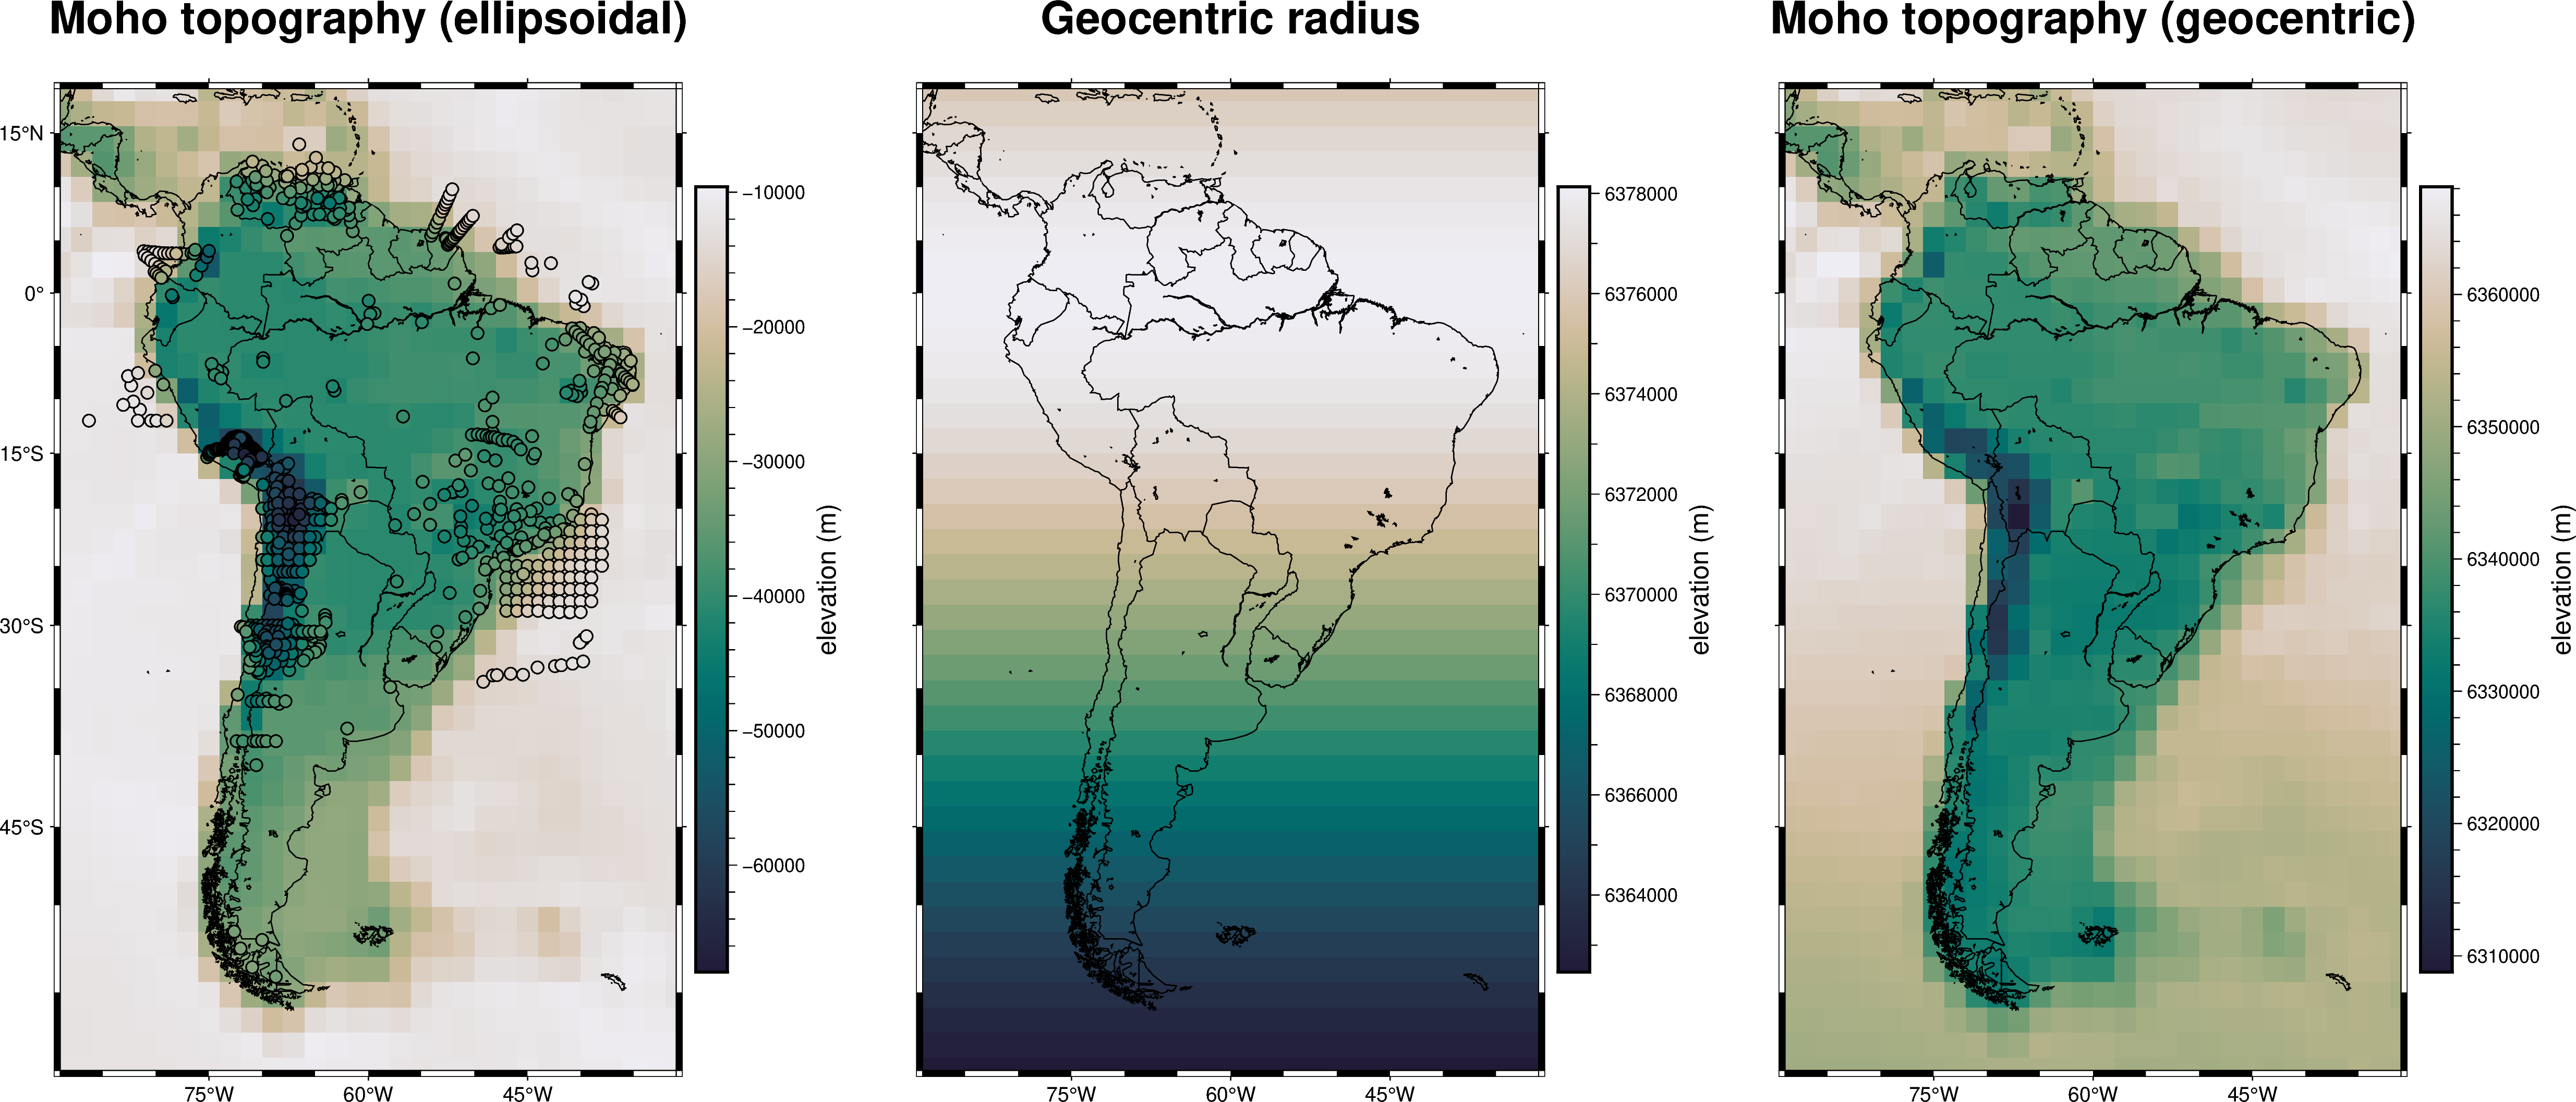

In [ ]:
fig = pygmt.Figure()
proj = "M10c"
# plot true moho topography relative to ellipsoid
pygmt.makecpt(
    cmap="rain",
    reverse=True,
    series=(polar_utils.get_min_max(true_moho.upward)),
    background=True,
)
fig.grdimage(
    true_moho.upward,
    projection=proj,
    frame=["neSW+tMoho topography (ellipsoidal)", "af"],
)
fig.colorbar(frame="af+lelevation (m)", position="JCR")
fig.coast(shorelines="0.5p,black", borders=["1/0.5p,black"])

# plot seismic points
fig.plot(
    x=constraint_points.longitude,
    y=constraint_points.latitude,
    style="c.2c",
    fill=constraint_points.upward,
    cmap=True,
    pen=".6p,black",
)

fig.shift_origin(xshift="w+4c")

# plot geocentric radius
pygmt.makecpt(
    cmap="rain",
    reverse=True,
    series=(polar_utils.get_min_max(true_moho.geocentric_radius)),
    background=True,
)
fig.grdimage(
    true_moho.geocentric_radius,
    projection=proj,
    frame=["neSw+tGeocentric radius", "af"],
)
fig.colorbar(frame="af+lelevation (m)", position="JCR")
fig.coast(shorelines="0.5p,black", borders=["1/0.5p,black"])

fig.shift_origin(xshift="w+4c")

# plot true moho topography relative to center of the Earth
upward_geocentric = true_moho.upward + true_moho.geocentric_radius
pygmt.makecpt(
    cmap="rain",
    reverse=True,
    series=(polar_utils.get_min_max(upward_geocentric)),
    background=True,
)
fig.grdimage(
    upward_geocentric,
    projection=proj,
    frame=["neSw+tMoho topography (geocentric)", "af"],
)
fig.colorbar(frame="af+lelevation (m)", position="JCR")
fig.coast(shorelines="0.5p,black", borders=["1/0.5p,black"])

fig.show()

## Create tesseroid model

In [ ]:
# Define the reference level (height in meters).
# This is the Moho depth of the Normal Earth
true_zref = -30e3

# The density contrast is negative if the relief is below the reference
true_density_contrast = 350.0

# make tesseroid layer
true_model = invert4geom.create_model(
    zref=true_zref,
    density_contrast=true_density_contrast,
    topography=true_moho,
    model_type="tesseroids",
)
true_model

<xarray.Dataset> Size: 97kB
Dimensions:                (latitude: 40, longitude: 30)
Coordinates:
  * latitude               (latitude) float64 320B -59.0 -57.0 ... 17.0 19.0
  * longitude              (longitude) float64 240B -89.0 -87.0 ... -33.0 -31.0
    top                    (latitude, longitude) float64 10kB 6.35e+06 ... 6....
    bottom                 (latitude, longitude) float64 10kB 6.332e+06 ... 6...
Data variables:
    density                (latitude, longitude) float64 10kB 350.0 ... 350.0
    thickness              (latitude, longitude) float64 10kB 1.8e+04 ... 1.8...
    starting_topography    (latitude, longitude) float64 10kB 6.35e+06 ... 6....
    topography             (latitude, longitude) float64 10kB 6.35e+06 ... 6....
    mask                   (latitude, longitude) float64 10kB 1.0 1.0 ... 1.0
    geocentric_radius      (latitude, longitude) float64 10kB 6.362e+06 ... 6...
    upper_confining_layer  (latitude, longitude) float64 10kB nan nan ... nan
    lower_confining_layer  (latitude, longitude) float64 10kB nan nan ... nan
Attributes:
    inner_region:      (-89.0, -31.0, -59.0, 19.0)
    zref:              -30000.0
    density_contrast:  350.0
    region:            (-89.0, -31.0, -59.0, 19.0)
    spacing:           2.0
    dataset_type:      model
    model_type:        tesseroids
    coord_names:       ('longitude', 'latitude')

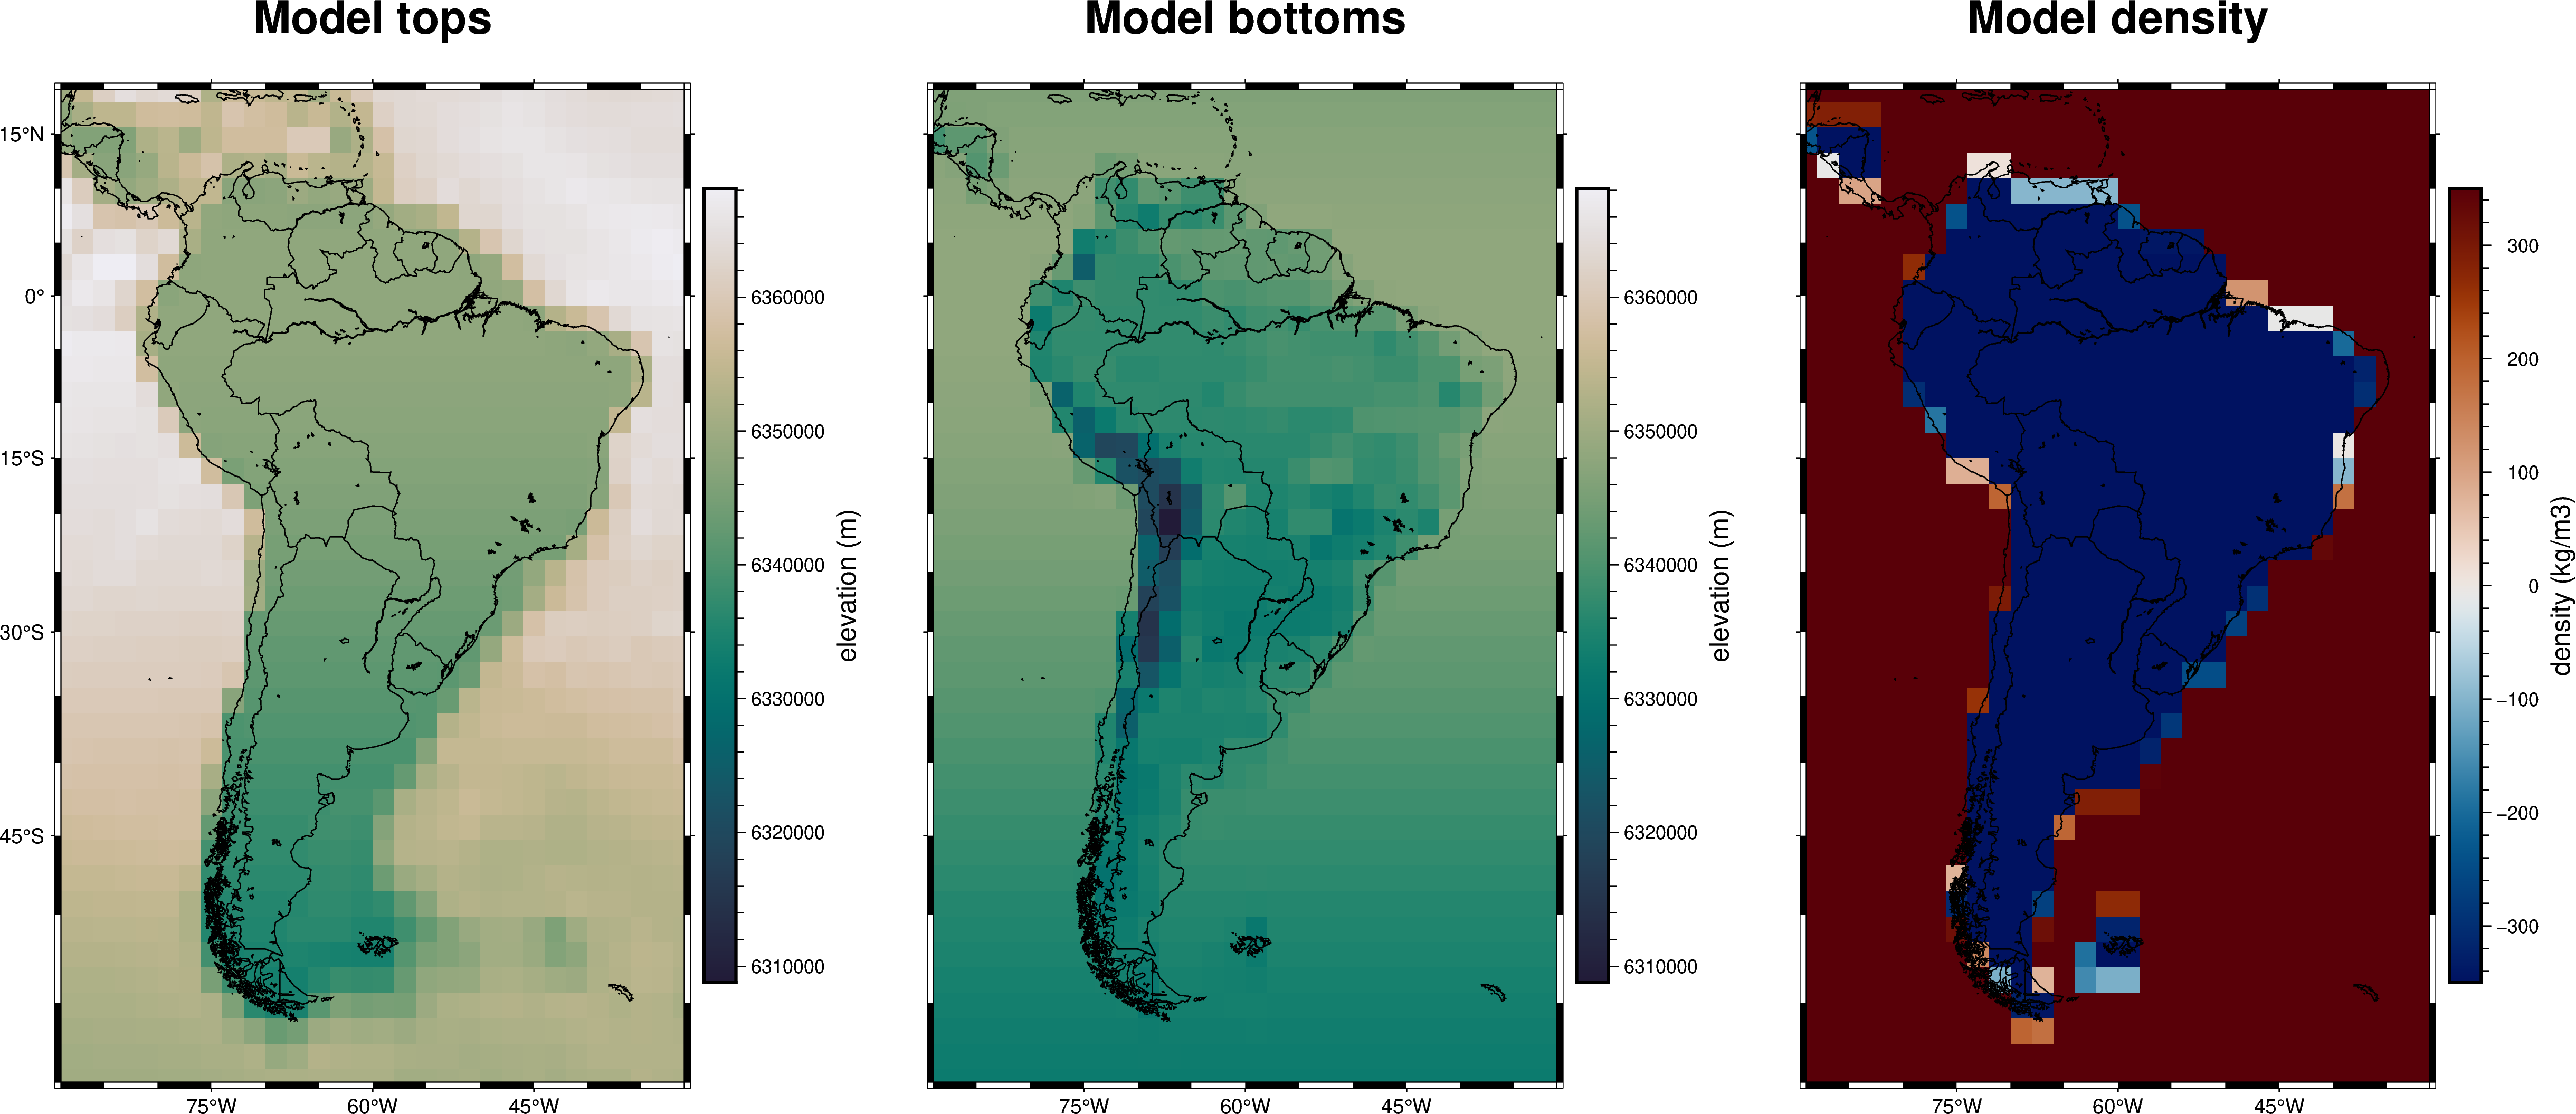

In [ ]:
fig = pygmt.Figure()
proj = "M10c"

# plot tesseroid tops
pygmt.makecpt(
    cmap="rain",
    reverse=True,
    series=(polar_utils.get_combined_min_max((true_model.top, true_model.bottom))),
    background=True,
)
fig.grdimage(true_model.top, projection=proj, frame=["neSW+tModel tops", "af"])
fig.colorbar(frame="af+lelevation (m)", position="JCR")
fig.coast(shorelines="0.5p,black", borders=["1/0.5p,black"])

fig.shift_origin(xshift="w+4c")

# plot tesseroid bottoms
fig.grdimage(true_model.bottom, projection=proj, frame=["neSw+tModel bottoms", "af"])
fig.colorbar(frame="af+lelevation (m)", position="JCR")
fig.coast(shorelines="0.5p,black", borders=["1/0.5p,black"])

fig.shift_origin(xshift="w+4c")

# # plot tesseroid densities
pygmt.makecpt(
    cmap="vik",
    background=True,
    series=polar_utils.get_min_max(true_model.density),
)
fig.grdimage(true_model.density, projection=proj, frame=["neSw+tModel density", "af"])
fig.colorbar(frame="af+ldensity (kg/m3)", position="JCR")
fig.coast(shorelines="0.5p,black", borders=["1/0.5p,black"])

fig.show()

## Observed gravity data
We can now forward-model the effects of this Moho model and add some noise to make a synthetic observed gravity dataset.

In [ ]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region_ll,
    spacing=spacing,
    pixel_register=False,
    extra_coords=50e3,  # survey elevation, ellipsoidal
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("latitude", "longitude"),
)

# get the coordinates of the grid
_longitude, latitude = np.meshgrid(observations.longitude, observations.latitude)

# compute the geocentric radius at each latitude
geocentric_radius = bl.WGS84.geocentric_radius(latitude)

# add geocentric radius to the xarray dataset
observations = observations.assign(
    geocentric_radius=(("latitude", "longitude"), geocentric_radius)
)

grav_data = invert4geom.create_data(
    observations,
    model_type="tesseroids",
)

grav_data.inv.forward_gravity(true_model, "gravity_anomaly")

# contaminate gravity with 5 mGal random noise
grav_data["gravity_anomaly"], stddev = invert4geom.contaminate(
    grav_data.gravity_anomaly,
    stddev=5,
    percent=False,
    seed=0,
)

grav_data

<xarray.Dataset> Size: 29kB
Dimensions:            (latitude: 40, longitude: 30)
Coordinates:
  * latitude           (latitude) float64 320B -59.0 -57.0 -55.0 ... 17.0 19.0
  * longitude          (longitude) float64 240B -89.0 -87.0 ... -33.0 -31.0
Data variables:
    upward             (latitude, longitude) float64 10kB 6.412e+06 ... 6.426...
    geocentric_radius  (latitude, longitude) float64 10kB 6.362e+06 ... 6.376...
    gravity_anomaly    (latitude, longitude) float64 10kB 178.8 213.2 ... 194.5
Attributes:
    region:        (-89.0, -31.0, -59.0, 19.0)
    spacing:       2.0
    buffer_width:  6.0
    inner_region:  (-83.0, -37.0, -53.0, 13.0)
    dataset_type:  data
    model_type:    tesseroids
    coord_names:   ('longitude', 'latitude')

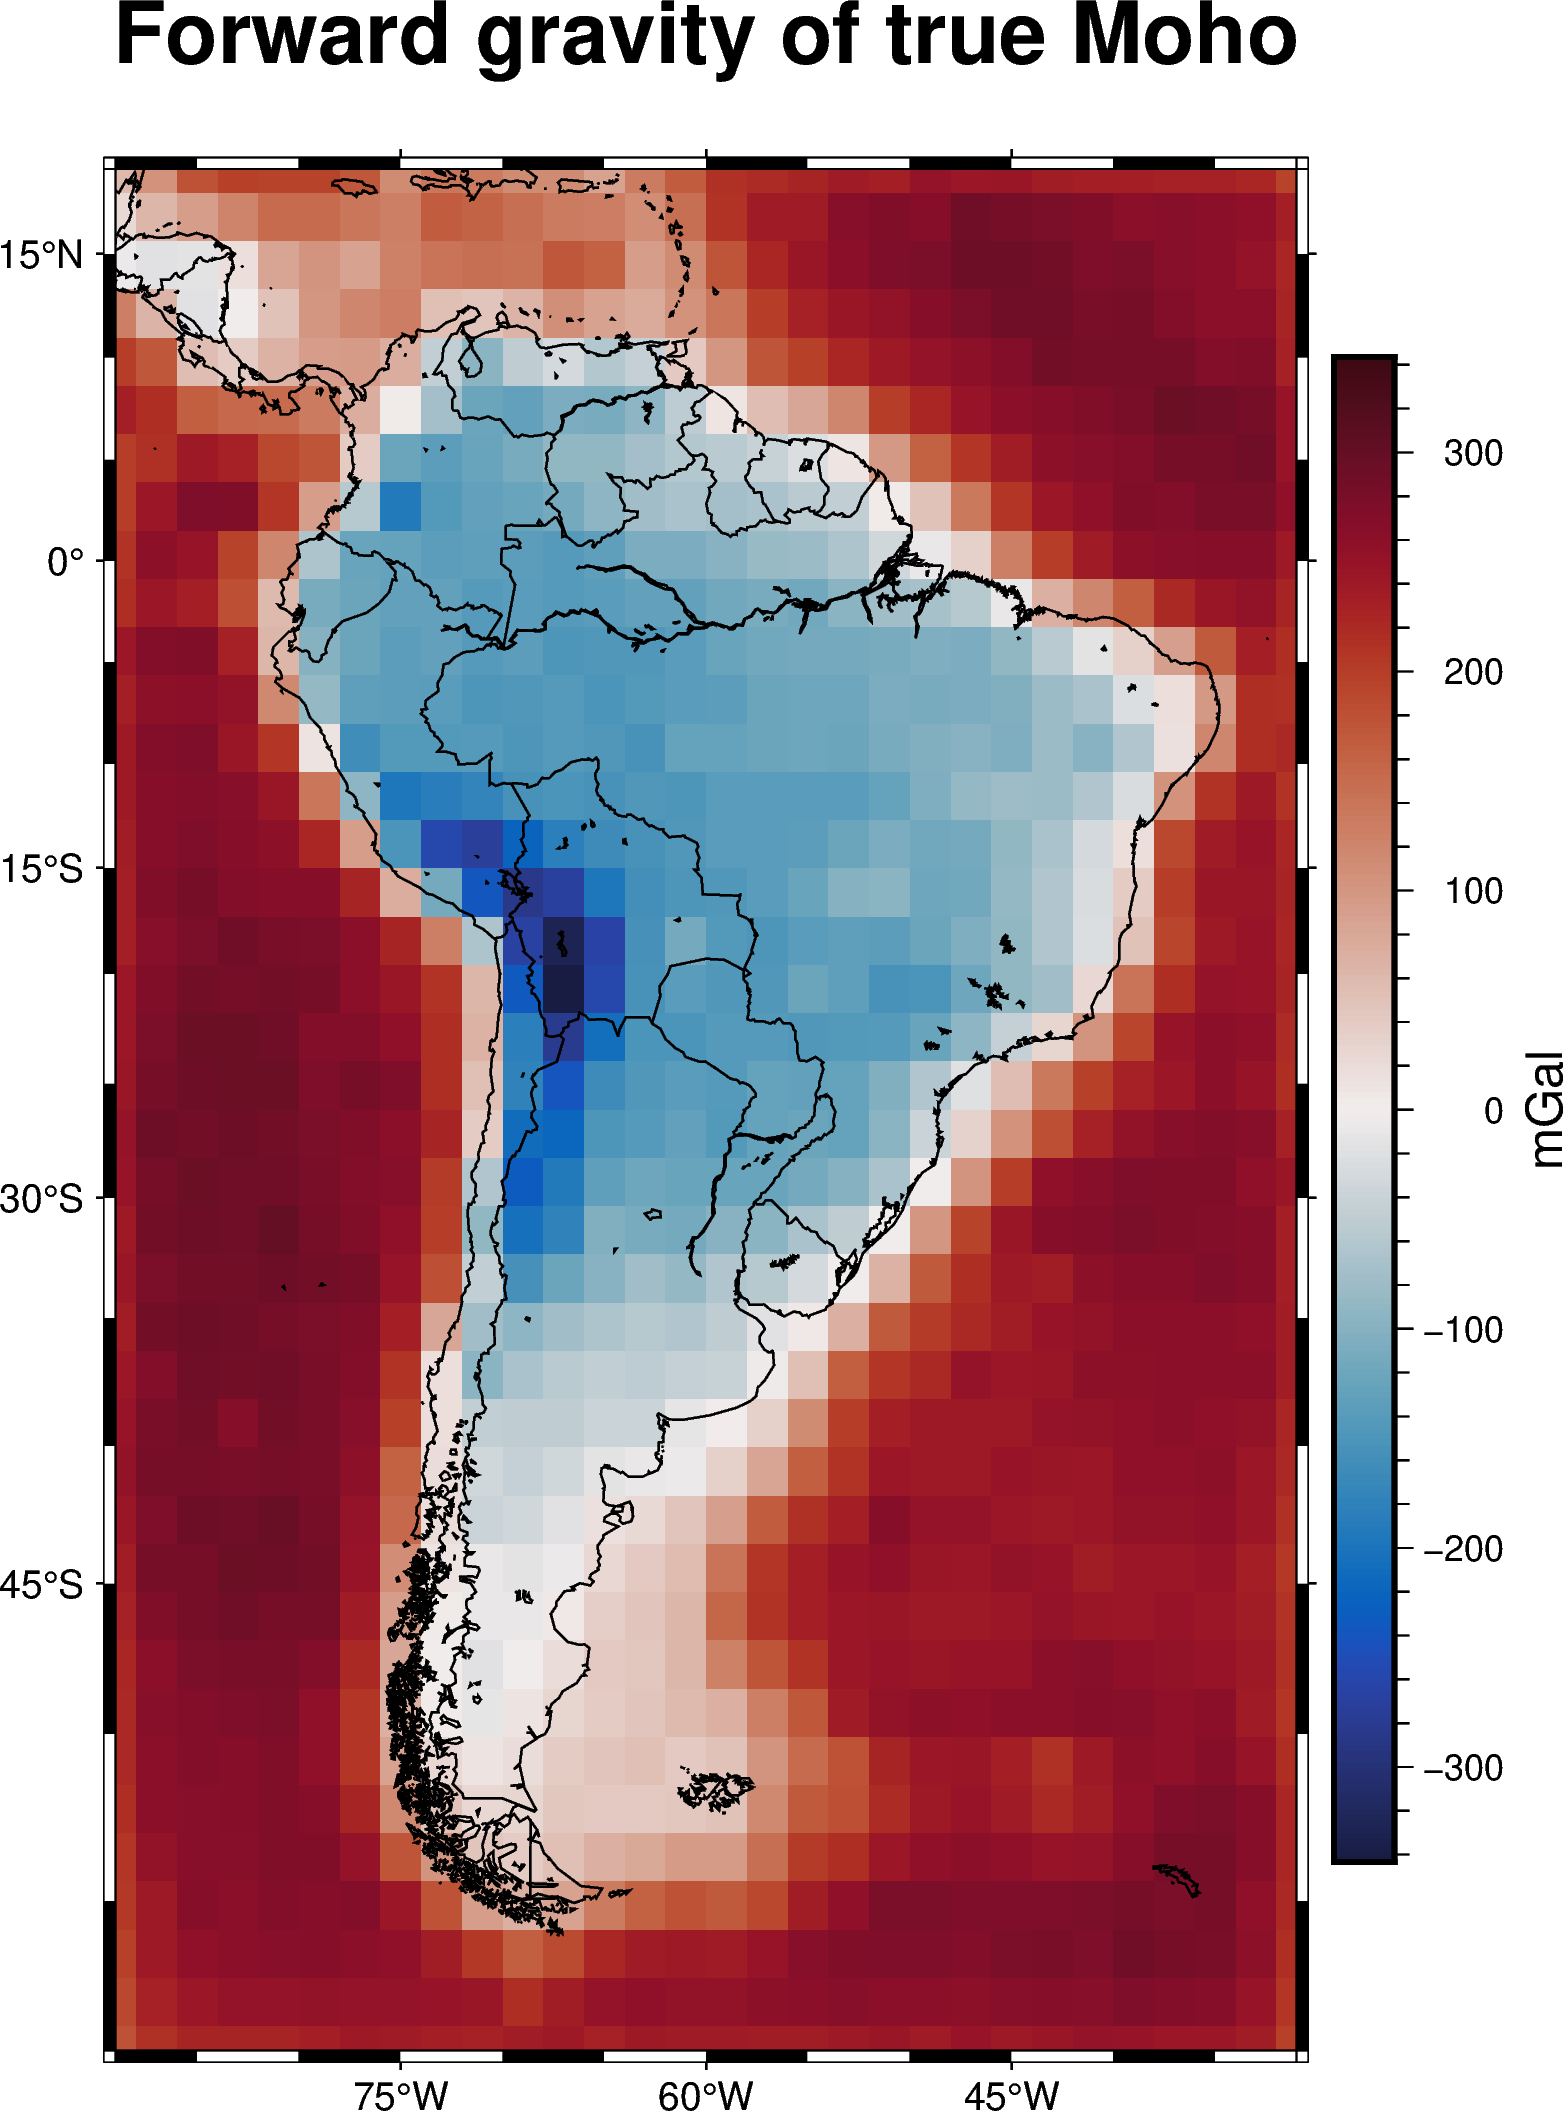

In [ ]:
fig = pygmt.Figure()
proj = "M10c"

# plot observed gravity
pygmt.makecpt(
    cmap="balance+h0",
    series=polar_utils.get_min_max(grav_data.gravity_anomaly, absolute=True),
    background=True,
)
fig.grdimage(
    grav_data.gravity_anomaly,
    projection=proj,
    frame=["neSW+tForward gravity of true Moho", "af"],
)
fig.colorbar(frame="af+lmGal", position="JCR")
fig.coast(shorelines="0.5p,black", borders=["1/0.5p,black"])
fig.show()

# Starting model
Following the paper's approach, we create a starting model which is a flat layer at 60 km depth, with a reference level of -20 km and a density contrast of 500 kg/m3. This is used during the damping parameter cross-validation.

In [ ]:
# create flat topography grid
starting_topography = xr.full_like(true_moho.upward, -60e3).to_dataset(name="upward")

starting_topography["geocentric_radius"] = true_moho.geocentric_radius

# create initial model
model = invert4geom.create_model(
    zref=-20e3,
    density_contrast=100,  # 500,
    topography=starting_topography,
    model_type="tesseroids",
    upper_confining_layer=xr.full_like(starting_topography.upward, 0),
)
model

<xarray.Dataset> Size: 97kB
Dimensions:                (latitude: 40, longitude: 30)
Coordinates:
  * latitude               (latitude) float64 320B -59.0 -57.0 ... 17.0 19.0
  * longitude              (longitude) float64 240B -89.0 -87.0 ... -33.0 -31.0
    top                    (latitude, longitude) float64 10kB 6.342e+06 ... 6...
    bottom                 (latitude, longitude) float64 10kB 6.302e+06 ... 6...
Data variables:
    density                (latitude, longitude) int64 10kB -100 -100 ... -100
    thickness              (latitude, longitude) float64 10kB 4e+04 ... 4e+04
    starting_topography    (latitude, longitude) float64 10kB 6.302e+06 ... 6...
    topography             (latitude, longitude) float64 10kB 6.302e+06 ... 6...
    mask                   (latitude, longitude) float64 10kB 1.0 1.0 ... 1.0
    geocentric_radius      (latitude, longitude) float64 10kB 6.362e+06 ... 6...
    upper_confining_layer  (latitude, longitude) float64 10kB 6.362e+06 ... 6...
    lower_confining_layer  (latitude, longitude) float64 10kB nan nan ... nan
Attributes:
    inner_region:      (-89.0, -31.0, -59.0, 19.0)
    zref:              -20000.0
    density_contrast:  100
    region:            (-89.0, -31.0, -59.0, 19.0)
    spacing:           2.0
    dataset_type:      model
    model_type:        tesseroids
    coord_names:       ('longitude', 'latitude')

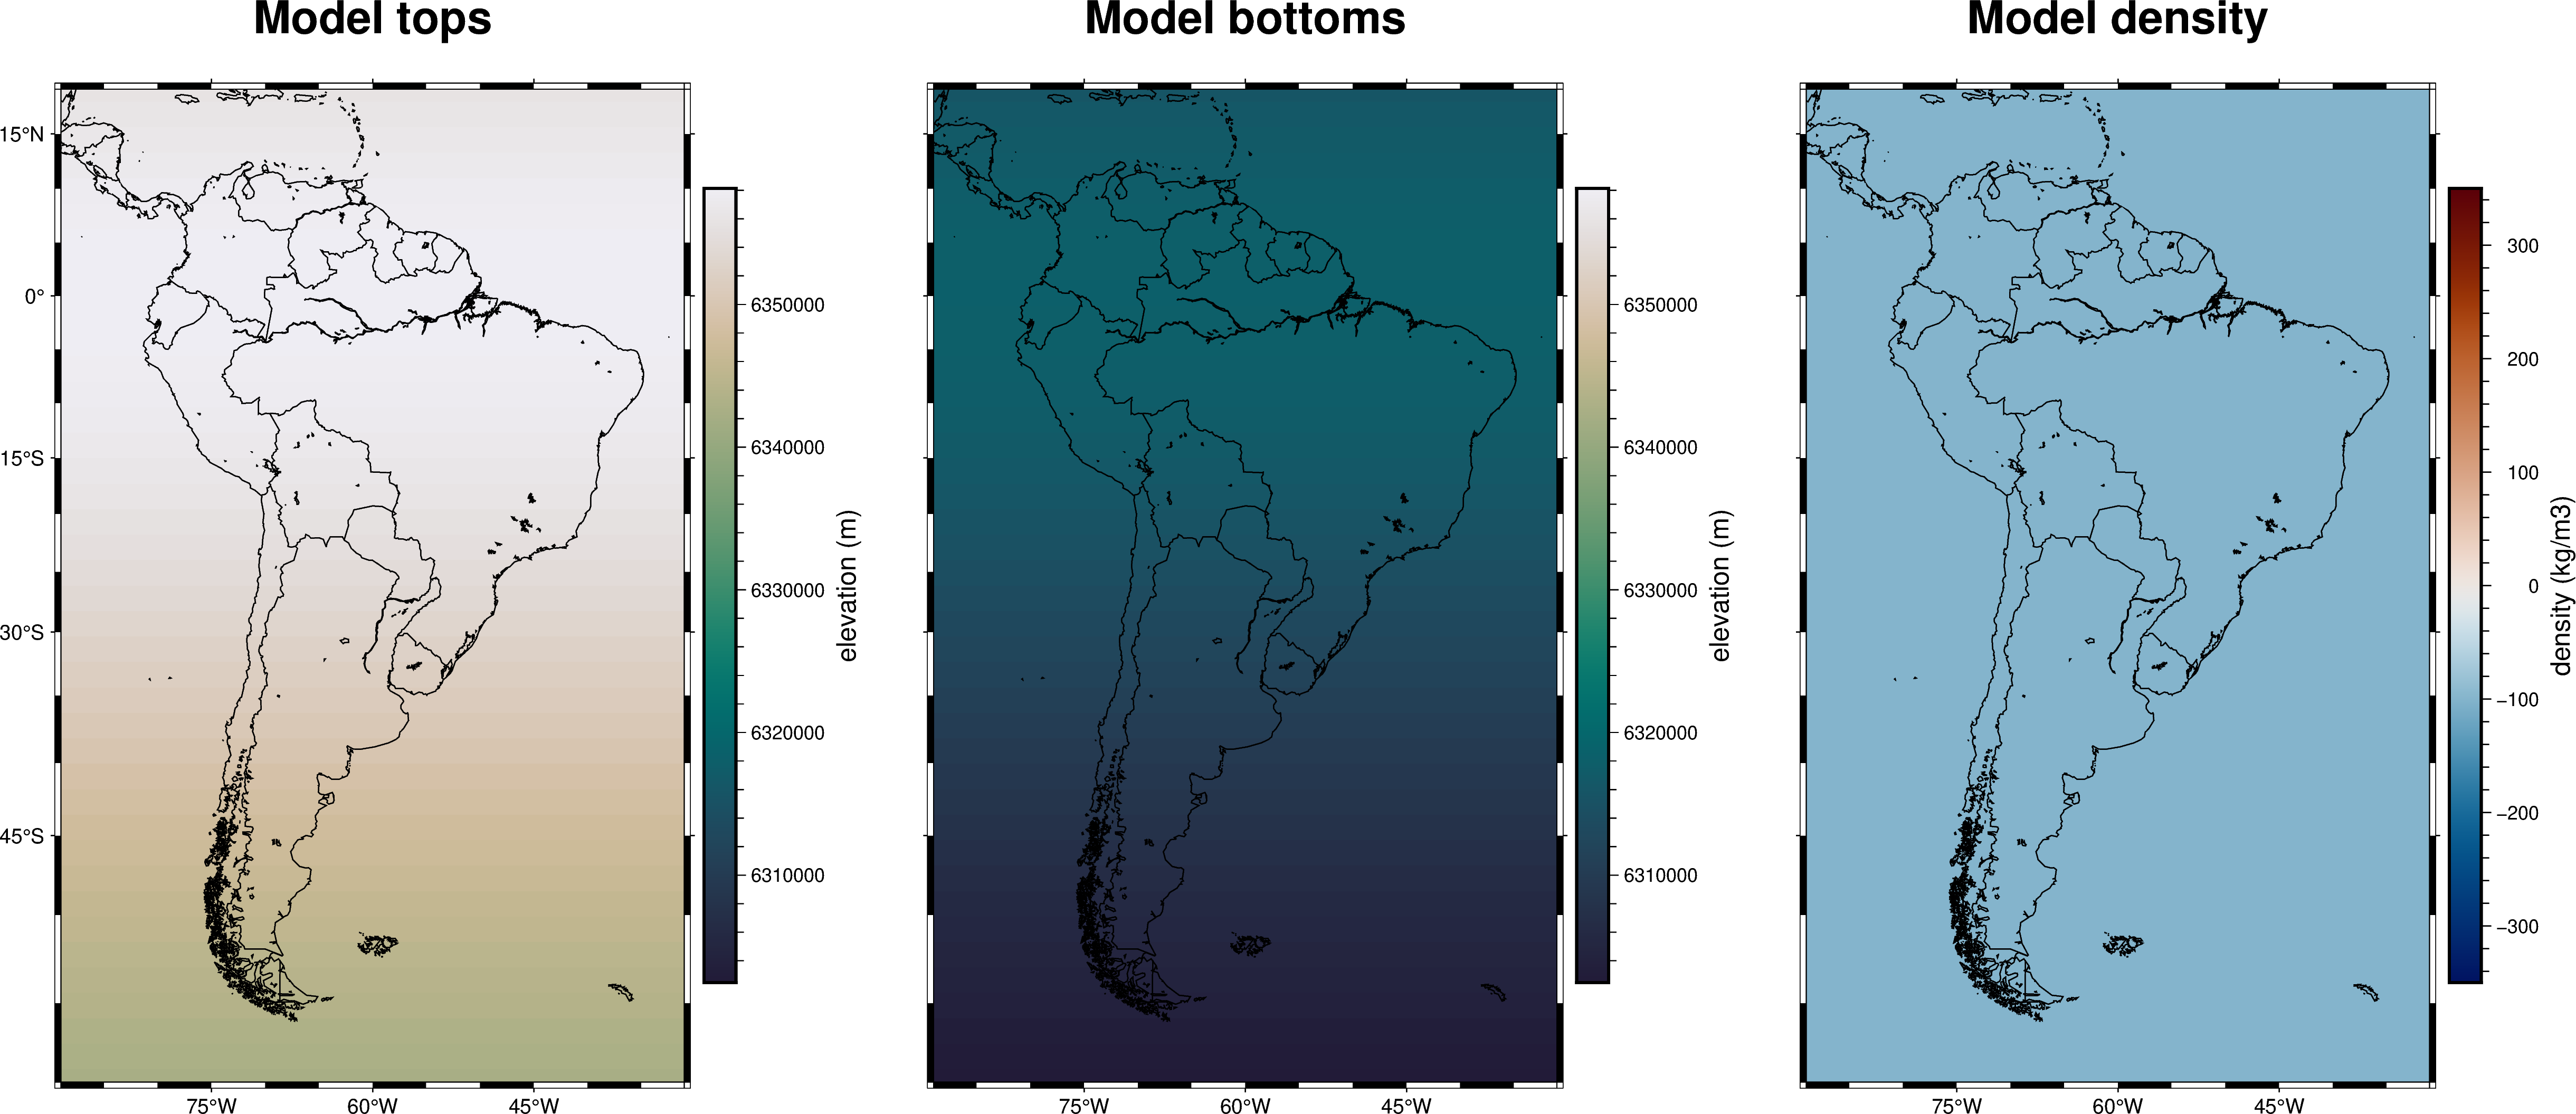

In [ ]:
fig = pygmt.Figure()
proj = "M10c"

# plot tesseroid tops
pygmt.makecpt(
    cmap="rain",
    reverse=True,
    series=(polar_utils.get_combined_min_max((model.top, model.bottom))),
    background=True,
)
fig.grdimage(model.top, projection=proj, frame=["neSW+tModel tops", "af"])
fig.colorbar(frame="af+lelevation (m)", position="JCR")
fig.coast(shorelines="0.5p,black", borders=["1/0.5p,black"])

fig.shift_origin(xshift="w+4c")

# plot tesseroid bottoms
fig.grdimage(model.bottom, projection=proj, frame=["neSw+tModel bottoms", "af"])
fig.colorbar(frame="af+lelevation (m)", position="JCR")
fig.coast(shorelines="0.5p,black", borders=["1/0.5p,black"])

fig.shift_origin(xshift="w+4c")

# # plot tesseroid densities
pygmt.makecpt(
    cmap="vik+h0",
    background=True,
    series=[-350, 350],
)
fig.grdimage(model.density, projection=proj, frame=["neSw+tModel density", "af"])
fig.colorbar(frame="af+ldensity (kg/m3)", position="JCR")
fig.coast(shorelines="0.5p,black", borders=["1/0.5p,black"])

fig.show()

In [ ]:
# calculate the forward gravity of the initial model
grav_data.inv.forward_gravity(
    model,
    progressbar=True,
)

# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and set
# it to 0
grav_data.inv.regional_separation(
    method="constant",
    constant=0,
)
grav_data.inv.df

  0%|          | 0/1200 [00:00<?, ?it/s]

latitude  longitude        upward  geocentric_radius  gravity_anomaly  \
0        -59.0      -89.0  6.412460e+06       6.362460e+06       178.806597   
1        -59.0      -87.0  6.412460e+06       6.362460e+06       213.223638   
2        -59.0      -85.0  6.412460e+06       6.362460e+06       226.627172   
3        -59.0      -83.0  6.412460e+06       6.362460e+06       227.875993   
4        -59.0      -81.0  6.412460e+06       6.362460e+06       226.983132   
...        ...        ...           ...                ...              ...   
1195      19.0      -39.0  6.425887e+06       6.375887e+06       232.714938   
1196      19.0      -37.0  6.425887e+06       6.375887e+06       230.113213   
1197      19.0      -35.0  6.425887e+06       6.375887e+06       228.485861   
1198      19.0      -33.0  6.425887e+06       6.375887e+06       225.113264   
1199      19.0      -31.0  6.425887e+06       6.375887e+06       194.539430   

      forward_gravity      misfit  reg         res  starting_forward_gravity  \
0         -119.359312  298.165909  0.0  298.165909               -119.359312   
1         -142.719345  355.942983  0.0  355.942983               -142.719345   
2         -150.270433  376.897605  0.0  376.897605               -150.270433   
3         -153.880084  381.756077  0.0  381.756077               -153.880084   
4         -156.060990  383.044123  0.0  383.044123               -156.060990   
...               ...         ...  ...         ...                       ...   
1195      -158.602333  391.317271  0.0  391.317271               -158.602333   
1196      -157.007267  387.120480  0.0  387.120480               -157.007267   
1197      -154.577941  383.063801  0.0  383.063801               -154.577941   
1198      -149.821585  374.934849  0.0  374.934849               -149.821585   
1199      -131.568966  326.108396  0.0  326.108396               -131.568966   

      starting_misfit  starting_reg  starting_res  
0          298.165909           0.0    298.165909  
1          355.942983           0.0    355.942983  
2          376.897605           0.0    376.897605  
3          381.756077           0.0    381.756077  
4          383.044123           0.0    383.044123  
...               ...           ...           ...  
1195       391.317271           0.0    391.317271  
1196       387.120480           0.0    387.120480  
1197       383.063801           0.0    383.063801  
1198       374.934849           0.0    374.934849  
1199       326.108396           0.0    326.108396  

[1200 rows x 13 columns]

## Single inversion

In [ ]:
# setup the inversion
inv = invert4geom.Inversion(
    grav_data,
    model,
    deriv_type="finite_difference",
    solver_damping=1e-2,
    # set stopping criteria
    max_iterations=20,
    l2_norm_tolerance=1.5,  # gravity error is ~5 mGal or L2-norm of ~2.2
    delta_l2_norm_tolerance=1.001,
)

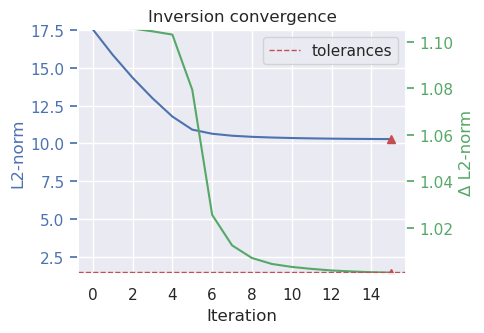

In [ ]:
inv.invert(plot_dynamic_convergence=True)

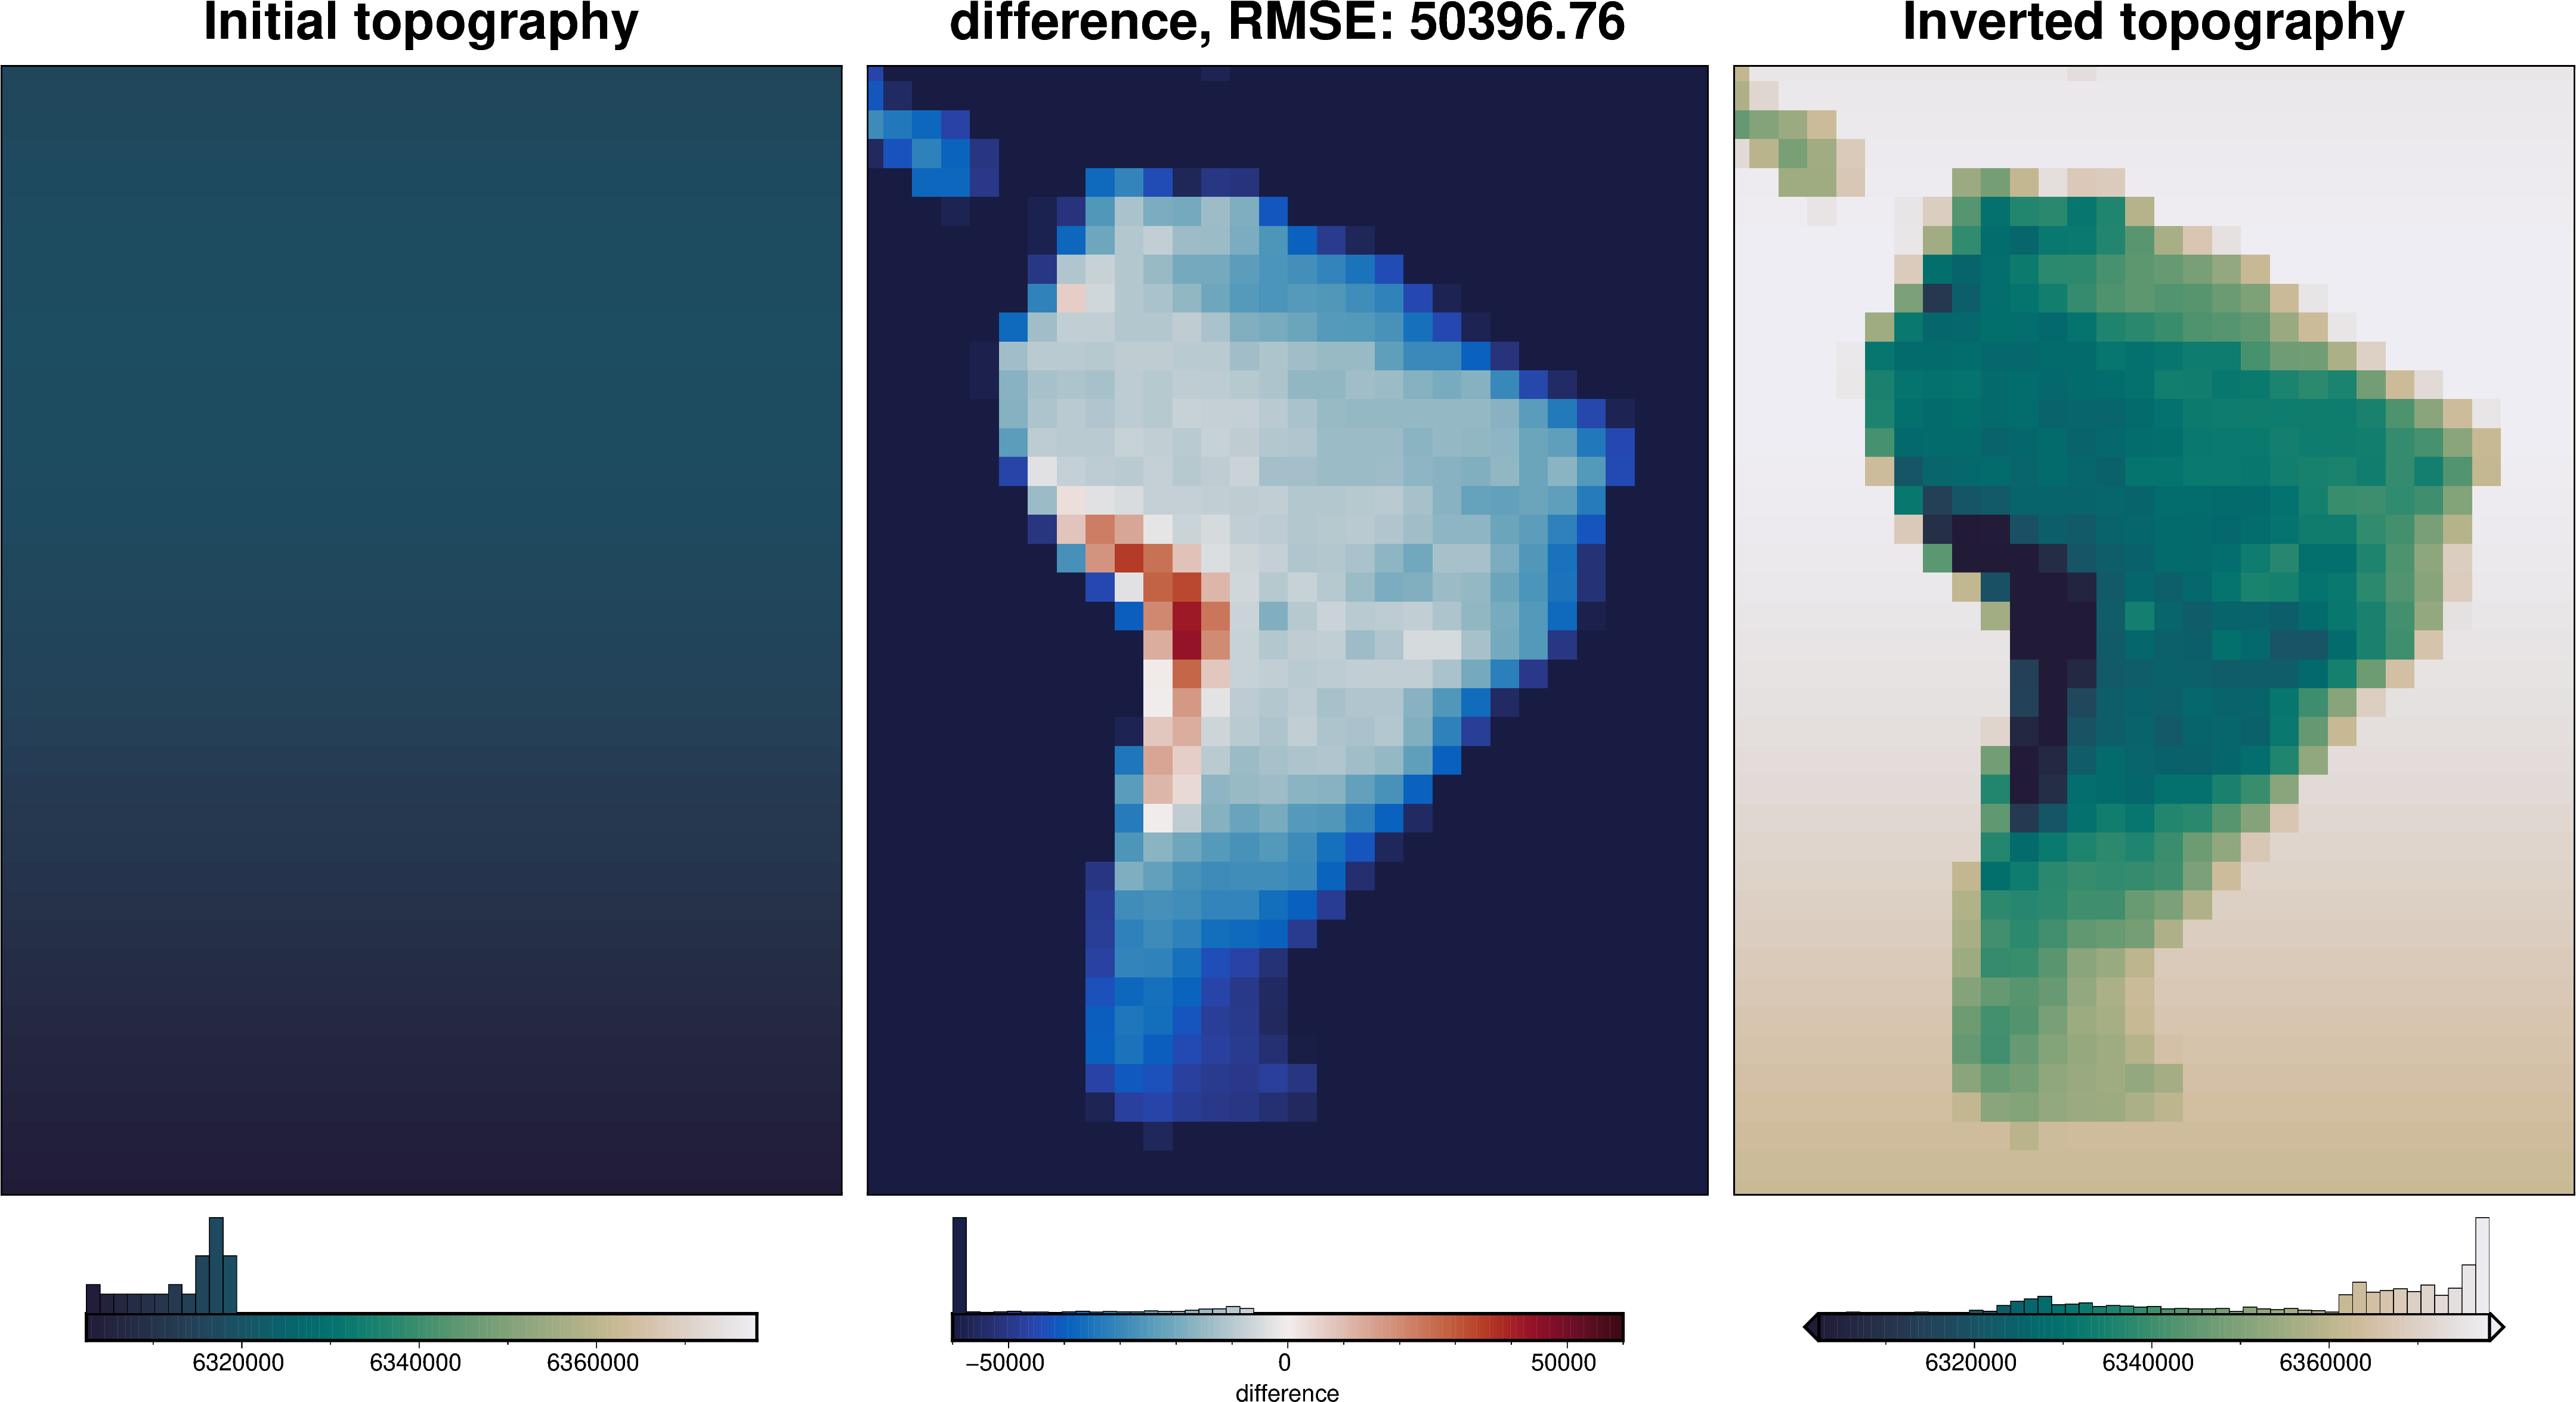

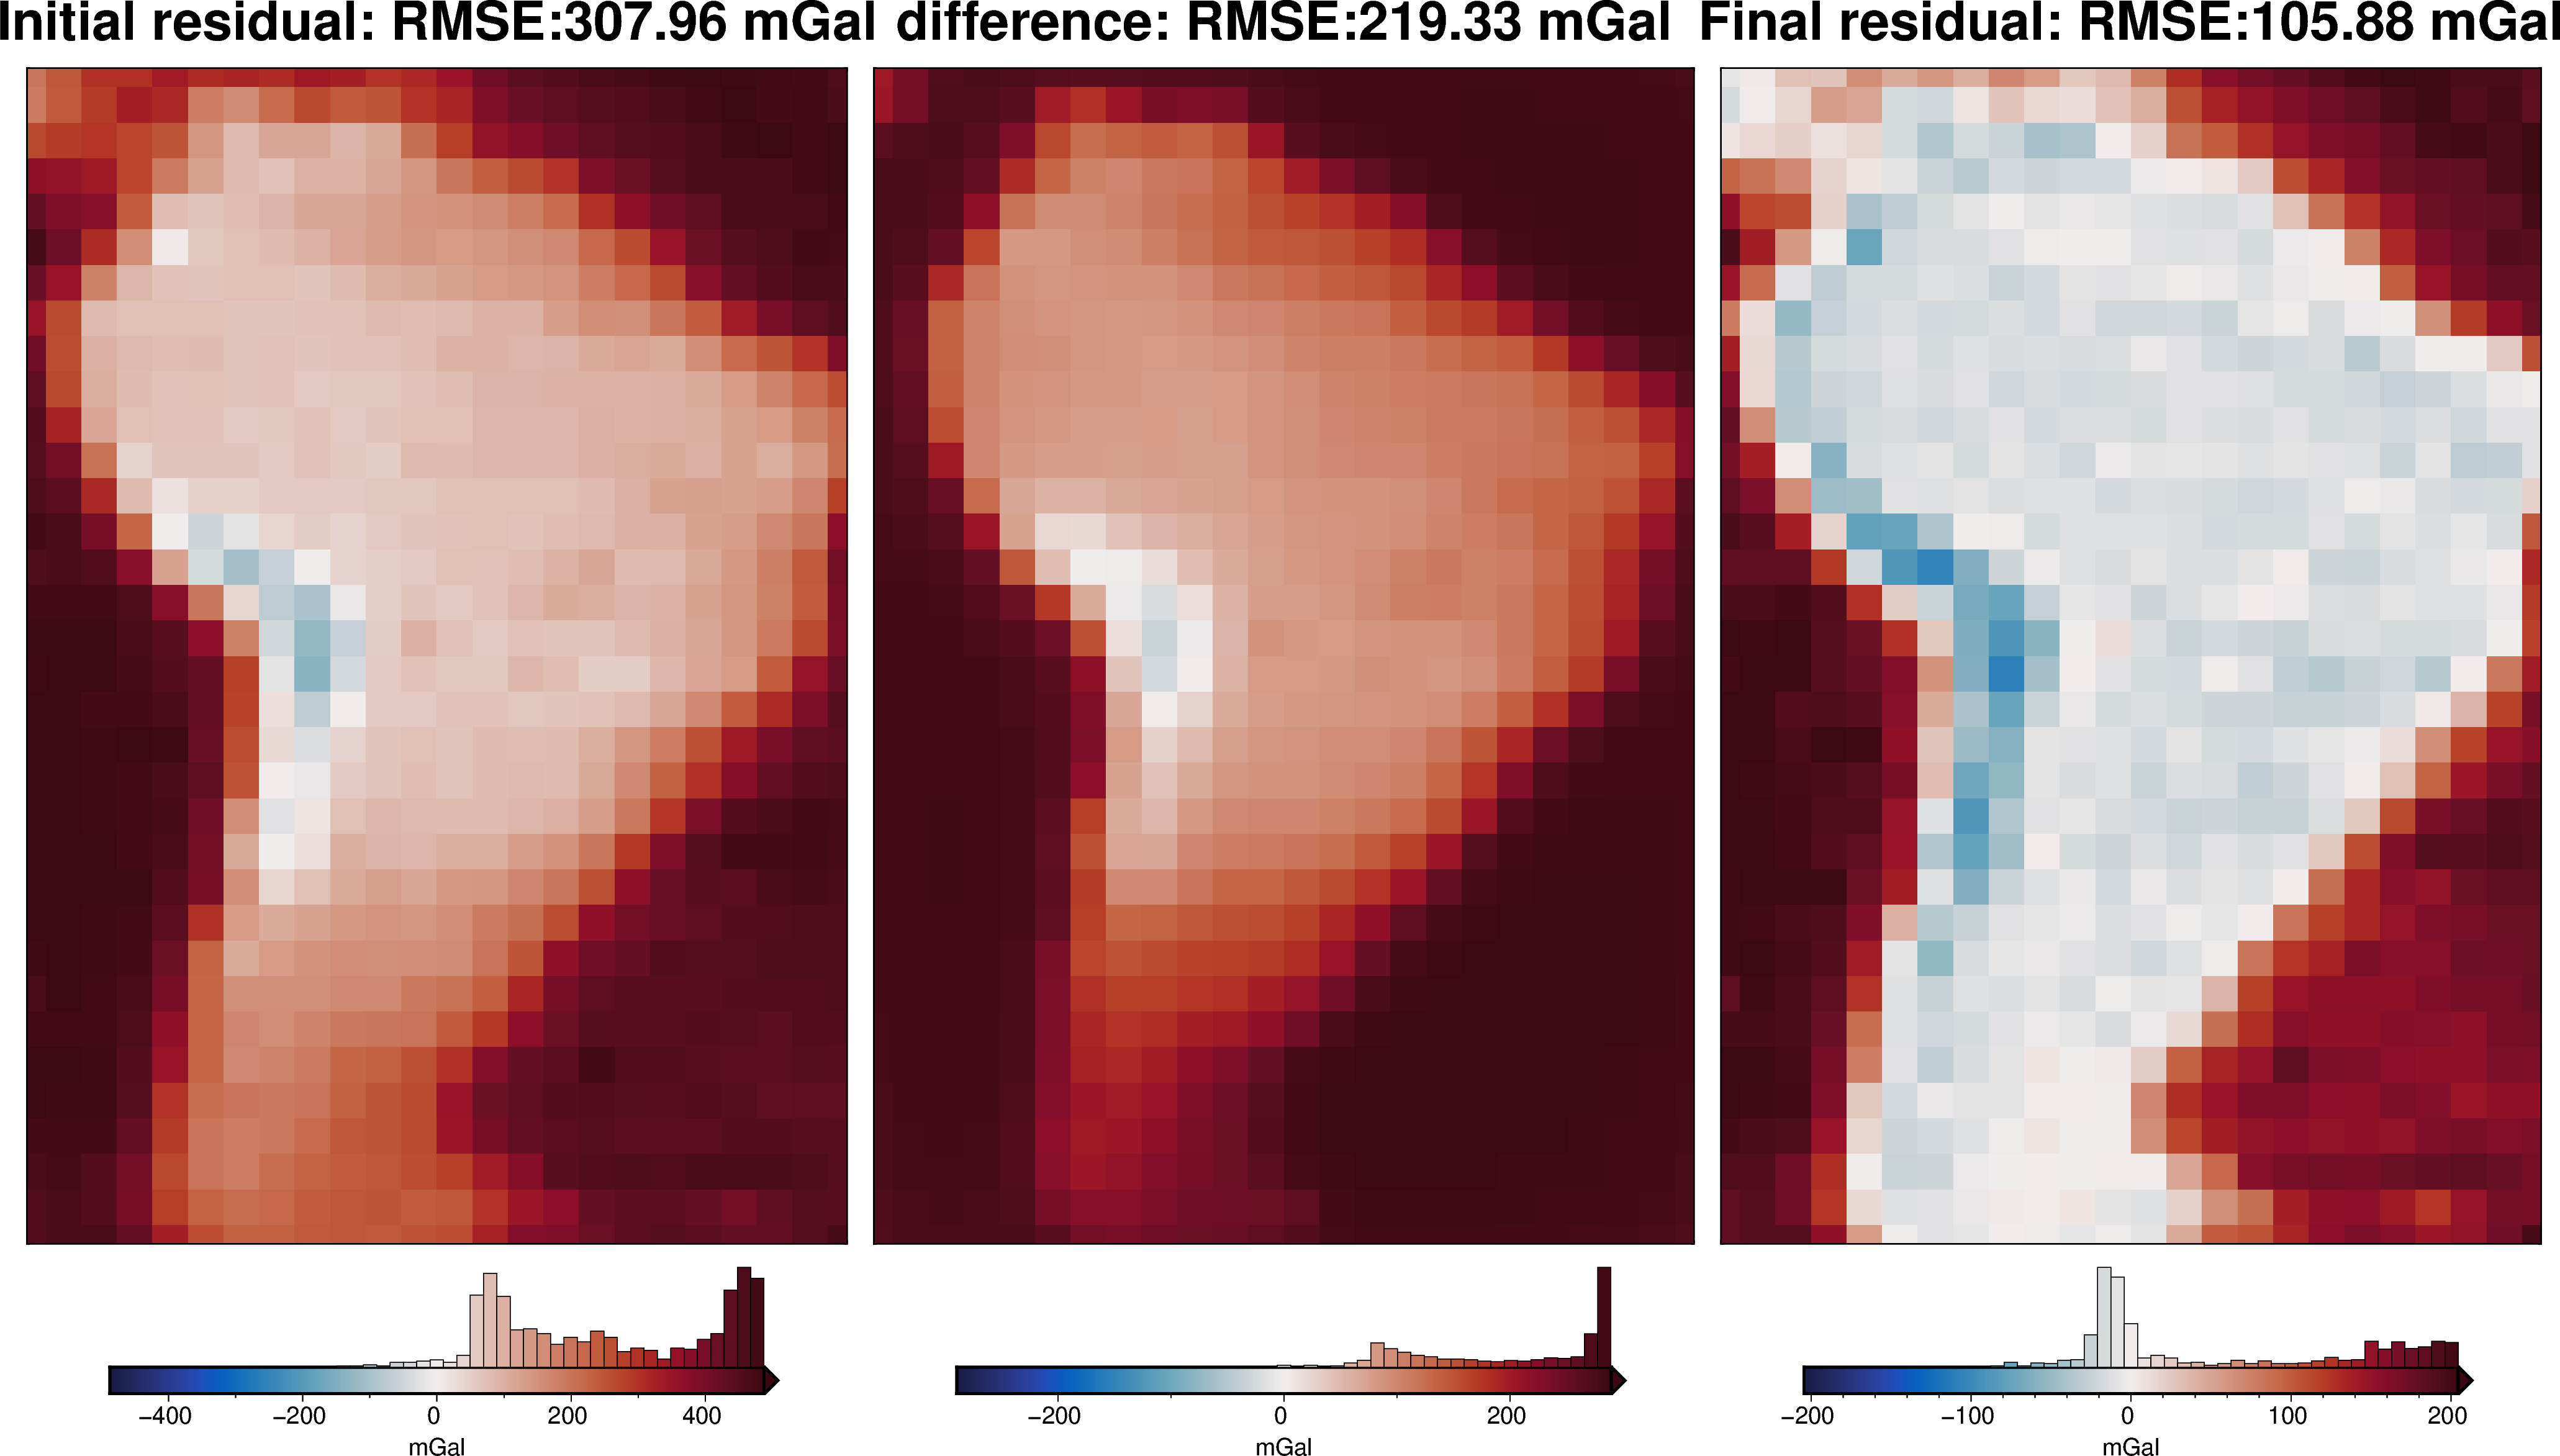

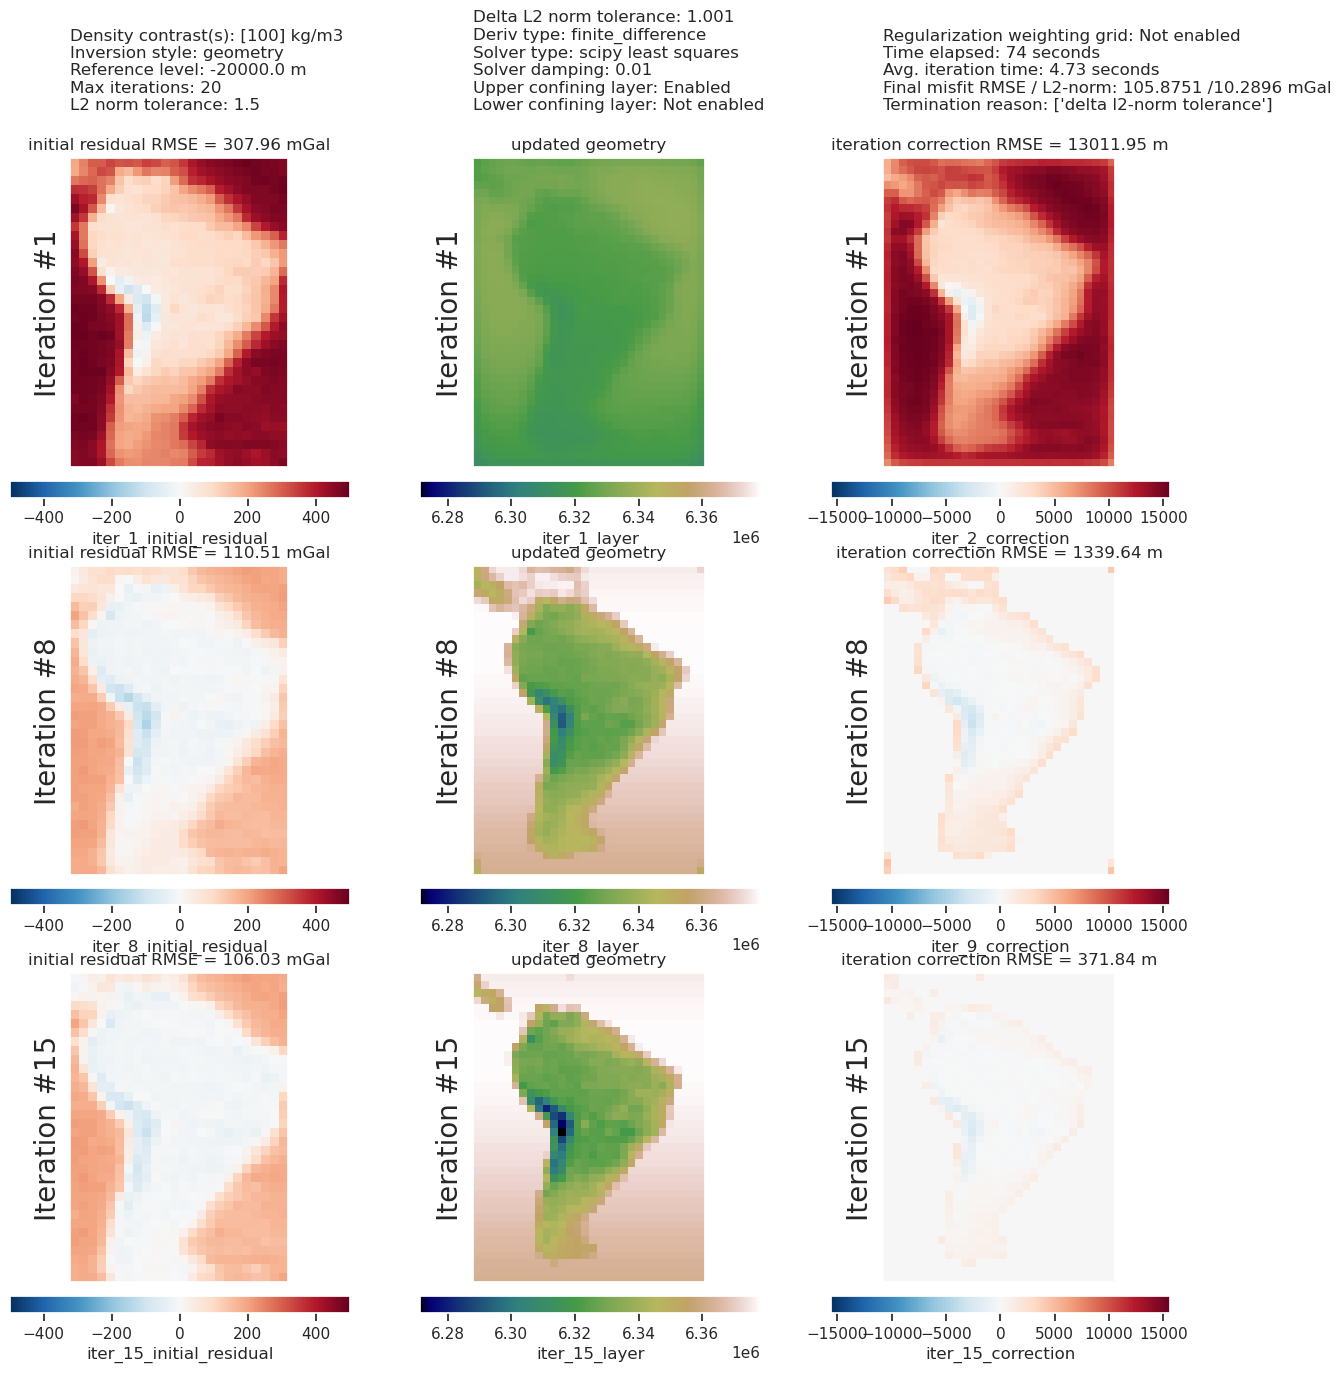

In [ ]:
inv.plot_inversion_results(
    iters_to_plot=3,
    fig_height=16,
)

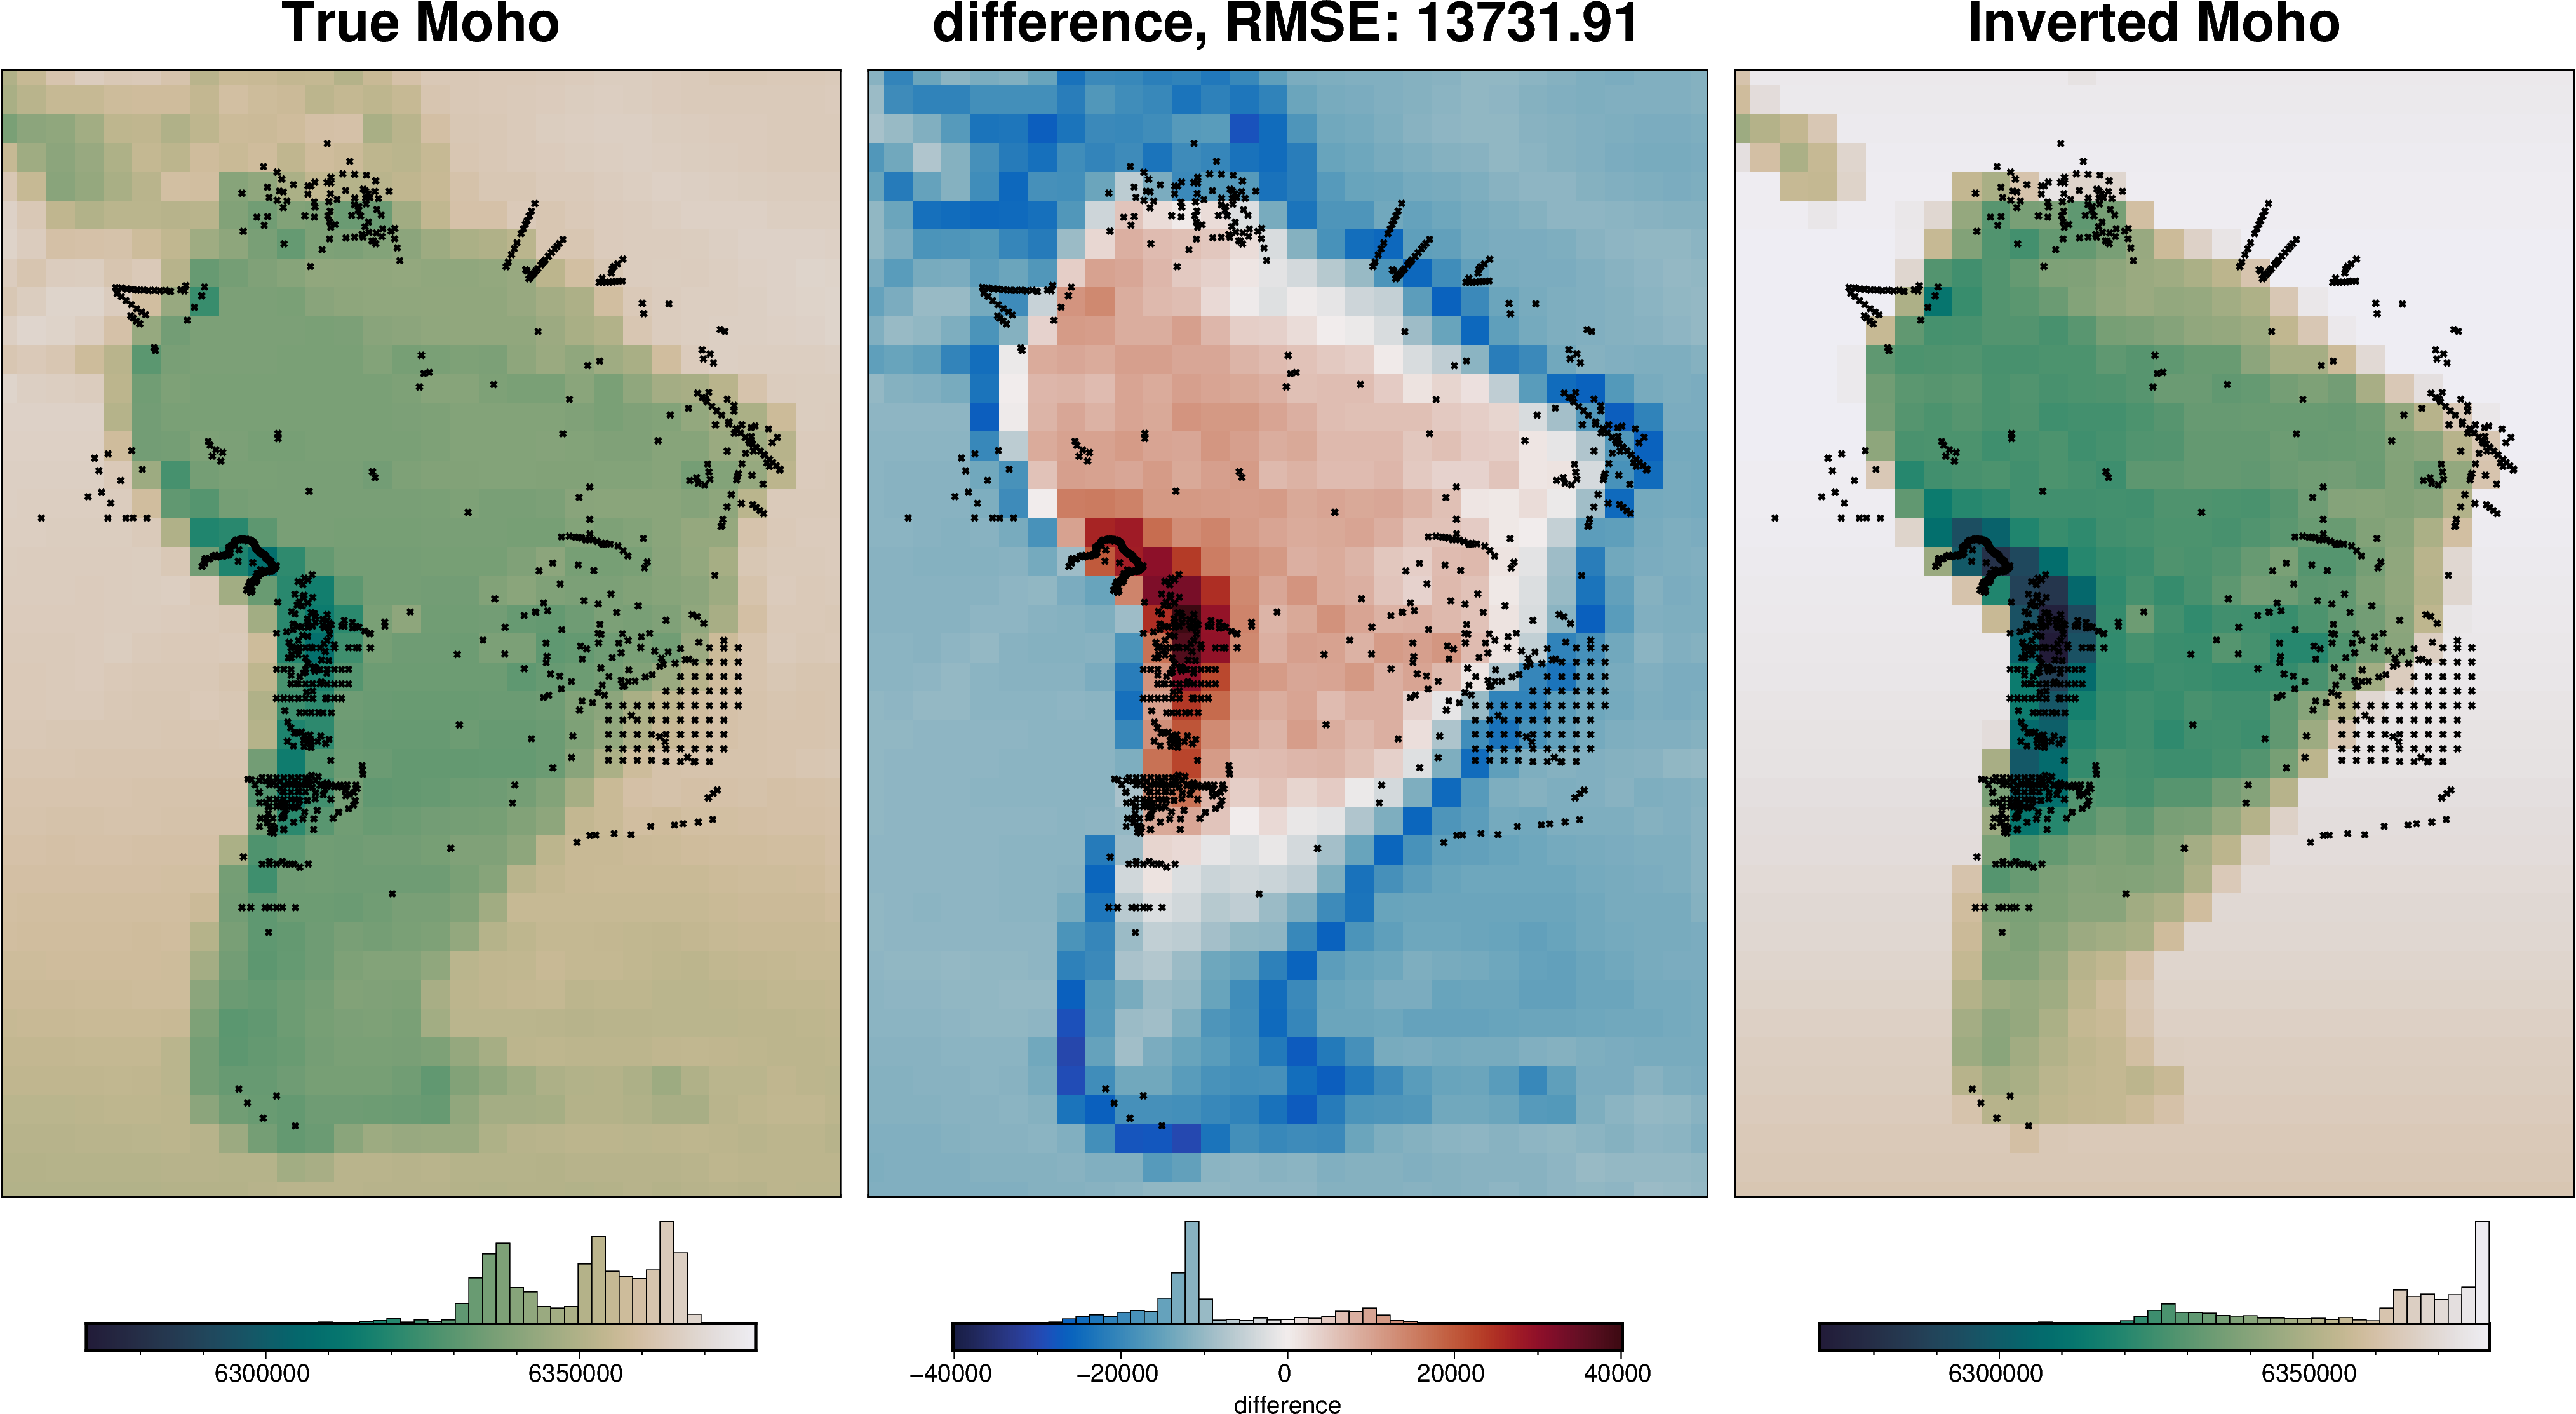

In [ ]:
_ = polar_utils.grd_compare(
    true_moho.upward + true_moho.geocentric_radius,
    inv.model.topography,
    grid1_name="True Moho",
    grid2_name="Inverted Moho",
    hist=True,
    inset=False,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"latitude": "y", "longitude": "x"}),
    points_style="x.1c",
)

## Damping parameter cross validation

In [72]:
inv.model

<xarray.Dataset> Size: 97kB
Dimensions:                (latitude: 40, longitude: 30)
Coordinates:
  * latitude               (latitude) float64 320B -59.0 -57.0 ... 17.0 19.0
  * longitude              (longitude) float64 240B -89.0 -87.0 ... -33.0 -31.0
    top                    (latitude, longitude) float64 10kB 6.342e+06 ... 6...
    bottom                 (latitude, longitude) float64 10kB 6.302e+06 ... 6...
Data variables:
    density                (latitude, longitude) int64 10kB -500 -500 ... -500
    thickness              (latitude, longitude) float64 10kB 4e+04 ... 4e+04
    starting_topography    (latitude, longitude) float64 10kB 6.302e+06 ... 6...
    topography             (latitude, longitude) float64 10kB 6.302e+06 ... 6...
    mask                   (latitude, longitude) float64 10kB 1.0 1.0 ... 1.0
    geocentric_radius      (latitude, longitude) float64 10kB 6.362e+06 ... 6...
    upper_confining_layer  (latitude, longitude) float64 10kB 6.362e+06 ... 6...
    lower_confining_layer  (latitude, longitude) float64 10kB nan nan ... nan
Attributes:
    inner_region:      (-89.0, -31.0, -59.0, 19.0)
    zref:              -20000.0
    density_contrast:  500
    region:            (-89.0, -31.0, -59.0, 19.0)
    spacing:           2.0
    dataset_type:      model
    model_type:        tesseroids
    coord_names:       ('longitude', 'latitude')

In [73]:
# re-initialize the inversion
inv.reinitialize_inversion()

In [75]:
# resample data at 1/2 spacing to include test points for cross-validation
inv.data = invert4geom.add_test_points(inv.data)
inv.data.inv.df

latitude  longitude   test     upward  geocentric_radius  \
0        -59.0      -89.0  False  6412460.0          6362460.0   
1        -59.0      -88.0   True  6412460.0          6362460.0   
2        -59.0      -87.0  False  6412460.0          6362460.0   
3        -59.0      -86.0   True  6412460.0          6362460.0   
4        -59.0      -85.0  False  6412460.0          6362460.0   
...        ...        ...    ...        ...                ...   
4656      19.0      -35.0  False  6425887.5          6375887.5   
4657      19.0      -34.0   True  6425887.5          6375887.5   
4658      19.0      -33.0  False  6425887.5          6375887.5   
4659      19.0      -32.0   True  6425887.5          6375887.5   
4660      19.0      -31.0  False  6425887.5          6375887.5   

      gravity_anomaly  forward_gravity       misfit  reg          res  \
0          178.806595      -596.796570   775.603149  0.0   775.603149   
1          197.328458      -660.136951   857.465405  0.0   857.465405   
2          213.223633      -713.596741   926.820374  0.0   926.820374   
3          221.998413      -738.646454   960.644848  0.0   960.644848   
4          226.627167      -751.352173   977.979309  0.0   977.979309   
...               ...              ...          ...  ...          ...   
4656       228.485855      -772.889709  1001.375549  0.0  1001.375549   
4657       228.608715      -765.943588   994.552303  0.0   994.552303   
4658       225.113266      -749.107910   974.221191  0.0   974.221191   
4659       211.526425      -707.693958   919.220394  0.0   919.220394   
4660       194.539429      -657.844849   852.384277  0.0   852.384277   

      starting_forward_gravity  starting_misfit  starting_reg  starting_res  
0                  -596.796570       775.603149           0.0    775.603149  
1                  -660.136951       857.465405           0.0    857.465405  
2                  -713.596741       926.820374           0.0    926.820374  
3                  -738.646454       960.644848           0.0    960.644848  
4                  -751.352173       977.979309           0.0    977.979309  
...                        ...              ...           ...           ...  
4656               -772.889709      1001.375549           0.0   1001.375549  
4657               -765.943588       994.552303           0.0    994.552303  
4658               -749.107910       974.221191           0.0    974.221191  
4659               -707.693958       919.220394           0.0    919.220394  
4660               -657.844849       852.384277           0.0    852.384277  

[4661 rows x 14 columns]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

5.414925548707758e-08

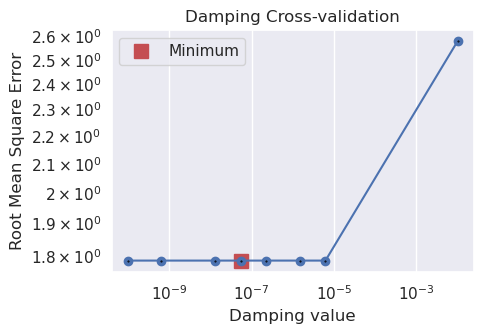

In [76]:
damping_cv_obj = inv.optimize_inversion_damping(
    damping_limits=(1e-10, 1e-2),
    n_trials=8,
    plot_scores=True,
    fname="../tmp/uieda_CRUST1_damping_CV",
)
inv.solver_damping

In [77]:
# to re-load the study from the saved pickle file
with pathlib.Path("../tmp/uieda_CRUST1_damping_CV_study.pickle").open("rb") as f:
    study = pickle.load(f)

In [78]:
study.trials_dataframe().sort_values("value")

number     value             datetime_start          datetime_complete  \
7       7  1.785890 2026-01-20 11:23:12.434676 2026-01-20 11:23:20.516453   
0       0  1.785892 2026-01-20 11:21:58.091001 2026-01-20 11:22:09.317758   
2       2  1.785892 2026-01-20 11:22:25.251713 2026-01-20 11:22:34.018379   
6       6  1.785892 2026-01-20 11:23:03.964417 2026-01-20 11:23:12.433181   
4       4  1.785893 2026-01-20 11:22:44.023507 2026-01-20 11:22:53.696774   
5       5  1.785893 2026-01-20 11:22:53.699528 2026-01-20 11:23:03.963235   
3       3  1.785893 2026-01-20 11:22:34.019695 2026-01-20 11:22:44.008810   
1       1  2.578882 2026-01-20 11:22:09.321338 2026-01-20 11:22:25.250484   

                duration  params_damping  \
7 0 days 00:00:08.081777    5.414926e-08   
0 0 days 00:00:11.226757    1.000000e-10   
2 0 days 00:00:08.766666    6.208322e-10   
6 0 days 00:00:08.468764    1.286719e-08   
4 0 days 00:00:09.673267    2.288707e-07   
5 0 days 00:00:10.263707    1.535827e-06   
3 0 days 00:00:09.989115    6.208322e-06   
1 0 days 00:00:15.929146    1.000000e-02   

                         user_attrs_fname system_attrs_fixed_params     state  
7  ../tmp/uieda_CRUST1_damping_CV_trial_7                       NaN  COMPLETE  
0  ../tmp/uieda_CRUST1_damping_CV_trial_0        {'damping': 1e-10}  COMPLETE  
2  ../tmp/uieda_CRUST1_damping_CV_trial_2                       NaN  COMPLETE  
6  ../tmp/uieda_CRUST1_damping_CV_trial_6                       NaN  COMPLETE  
4  ../tmp/uieda_CRUST1_damping_CV_trial_4                       NaN  COMPLETE  
5  ../tmp/uieda_CRUST1_damping_CV_trial_5                       NaN  COMPLETE  
3  ../tmp/uieda_CRUST1_damping_CV_trial_3                       NaN  COMPLETE  
1  ../tmp/uieda_CRUST1_damping_CV_trial_1         {'damping': 0.01}  COMPLETE

The above plot shows the results of the damping parameter cross validation, and is equivalent to Figure 7a in the paper. The main difference is that we use a optimization approach instead of a grid search. This allows us to find the best value in fewer trials, as the parameter search space is quickly narrowed down. We performed 8 trials, compared to the 16 trials used in the paper.

### Plot results

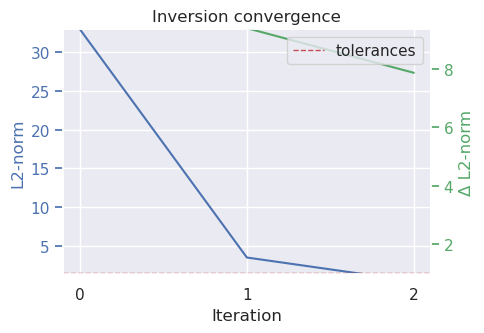

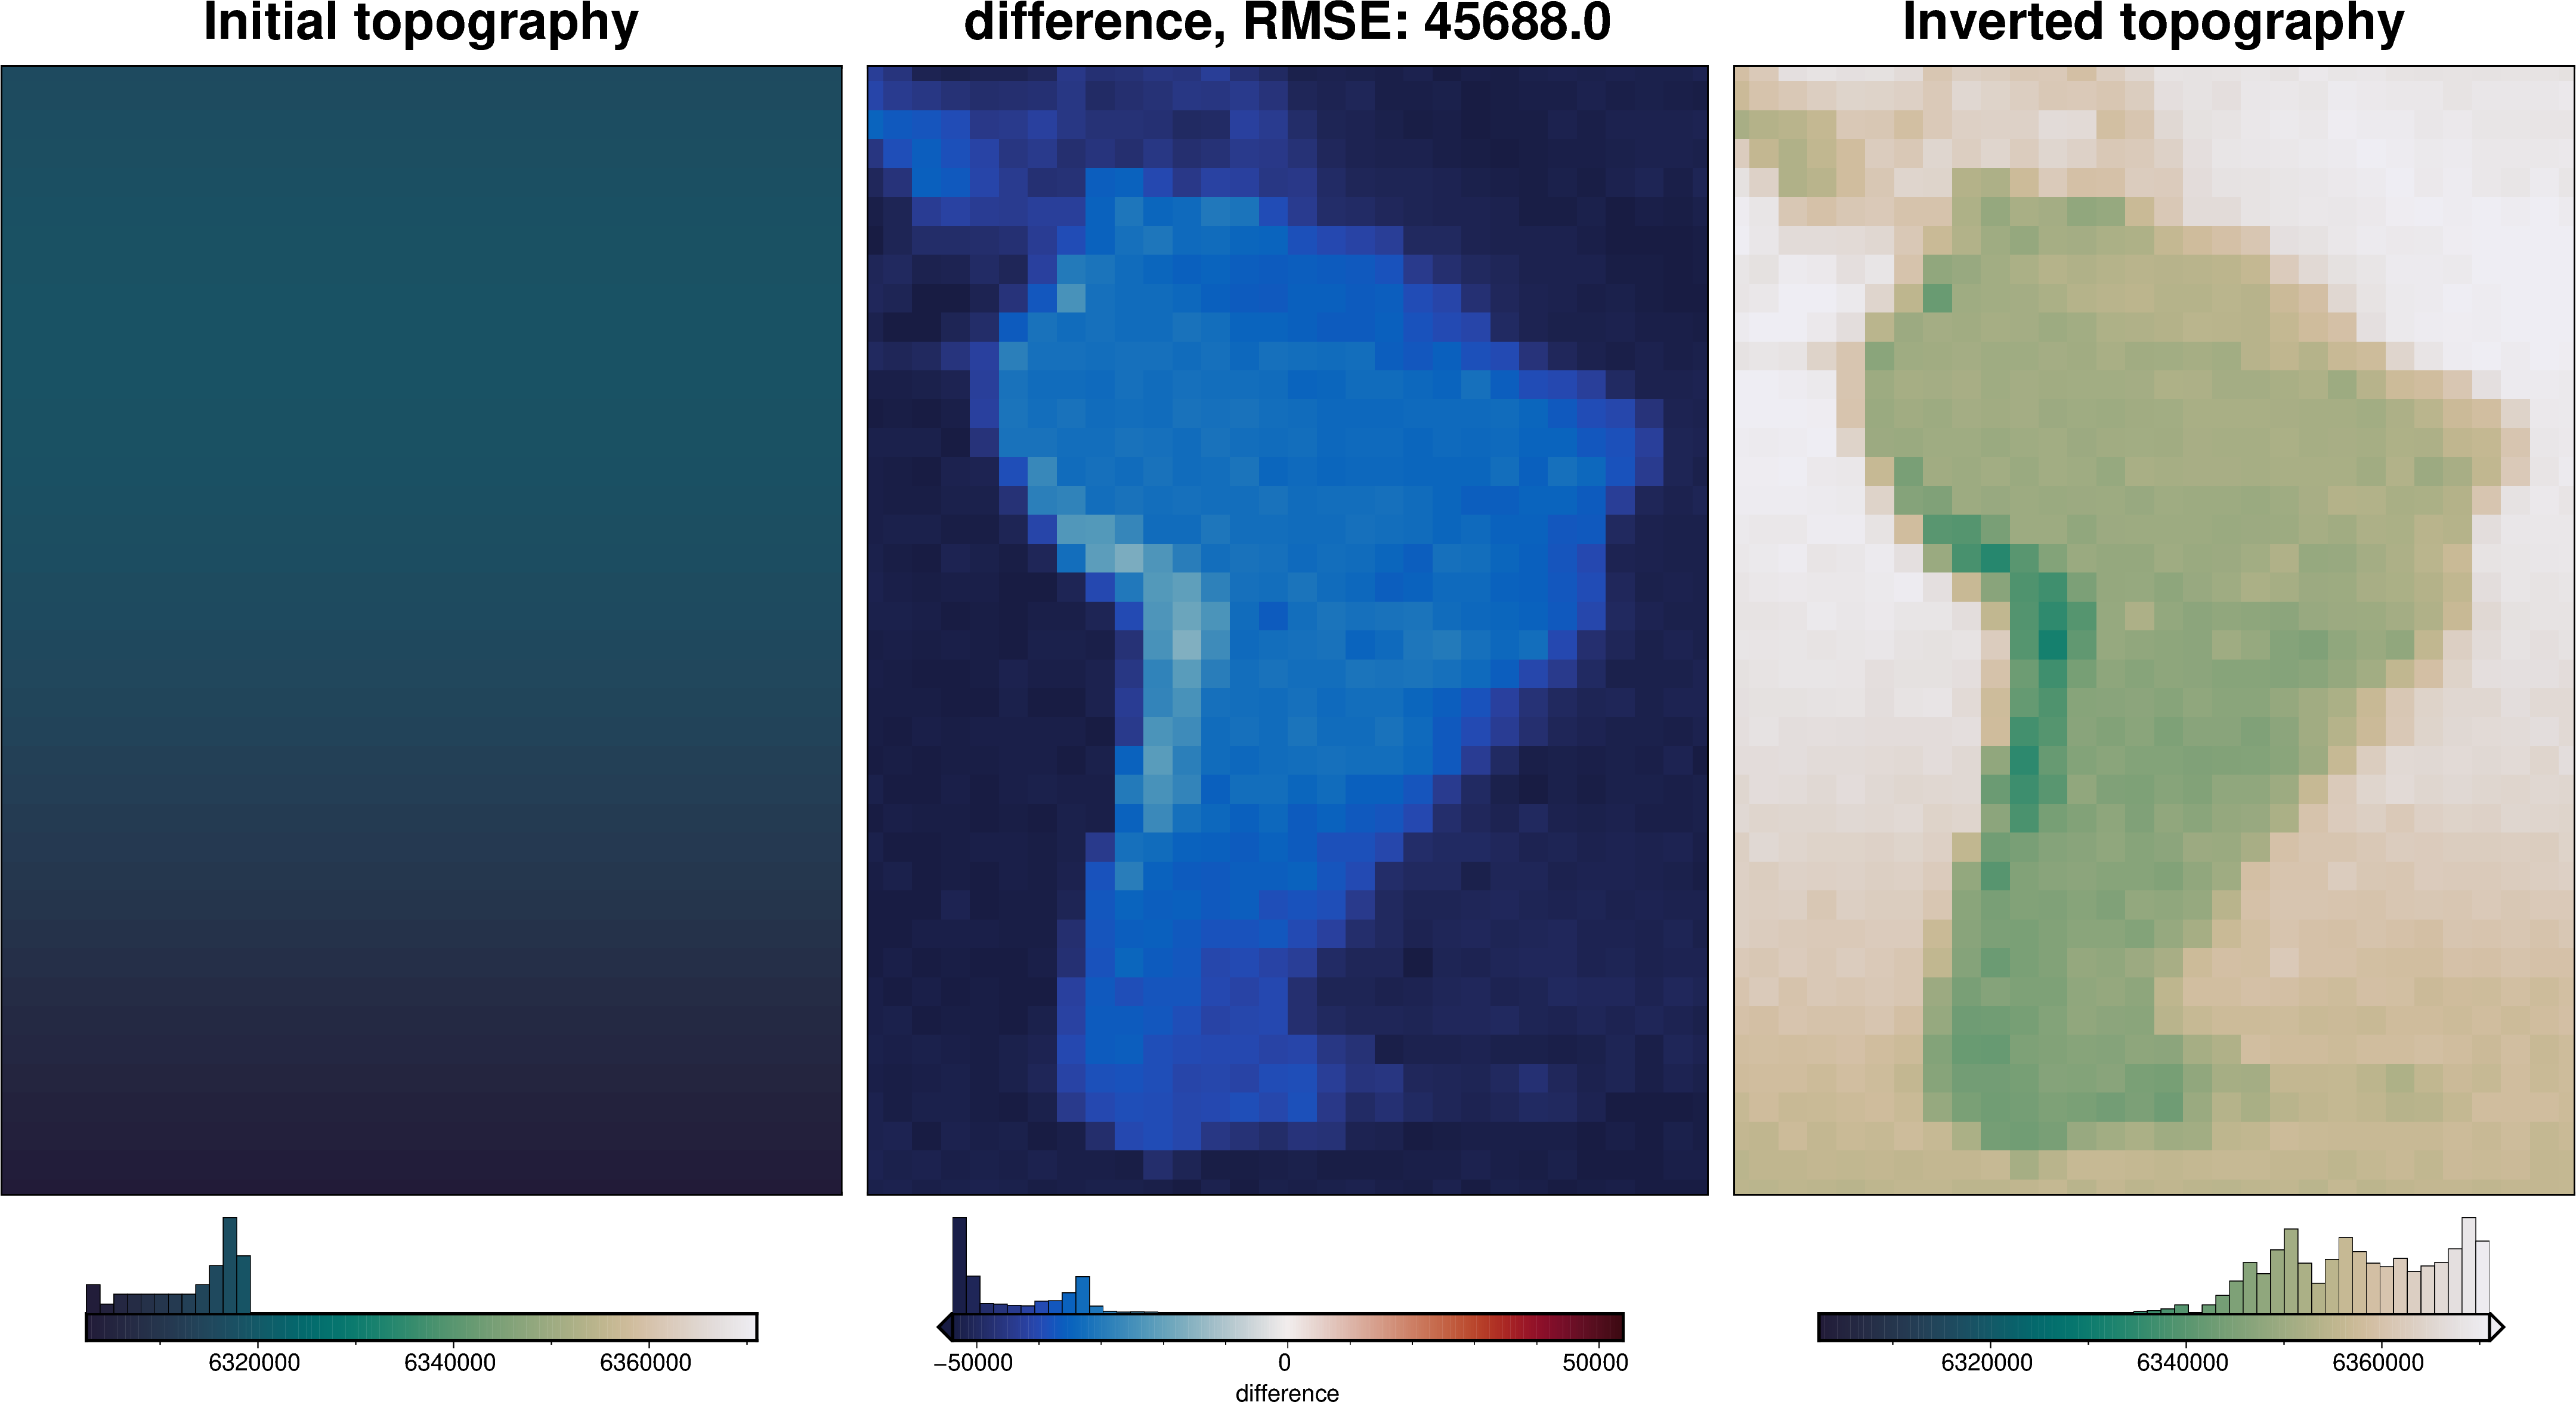

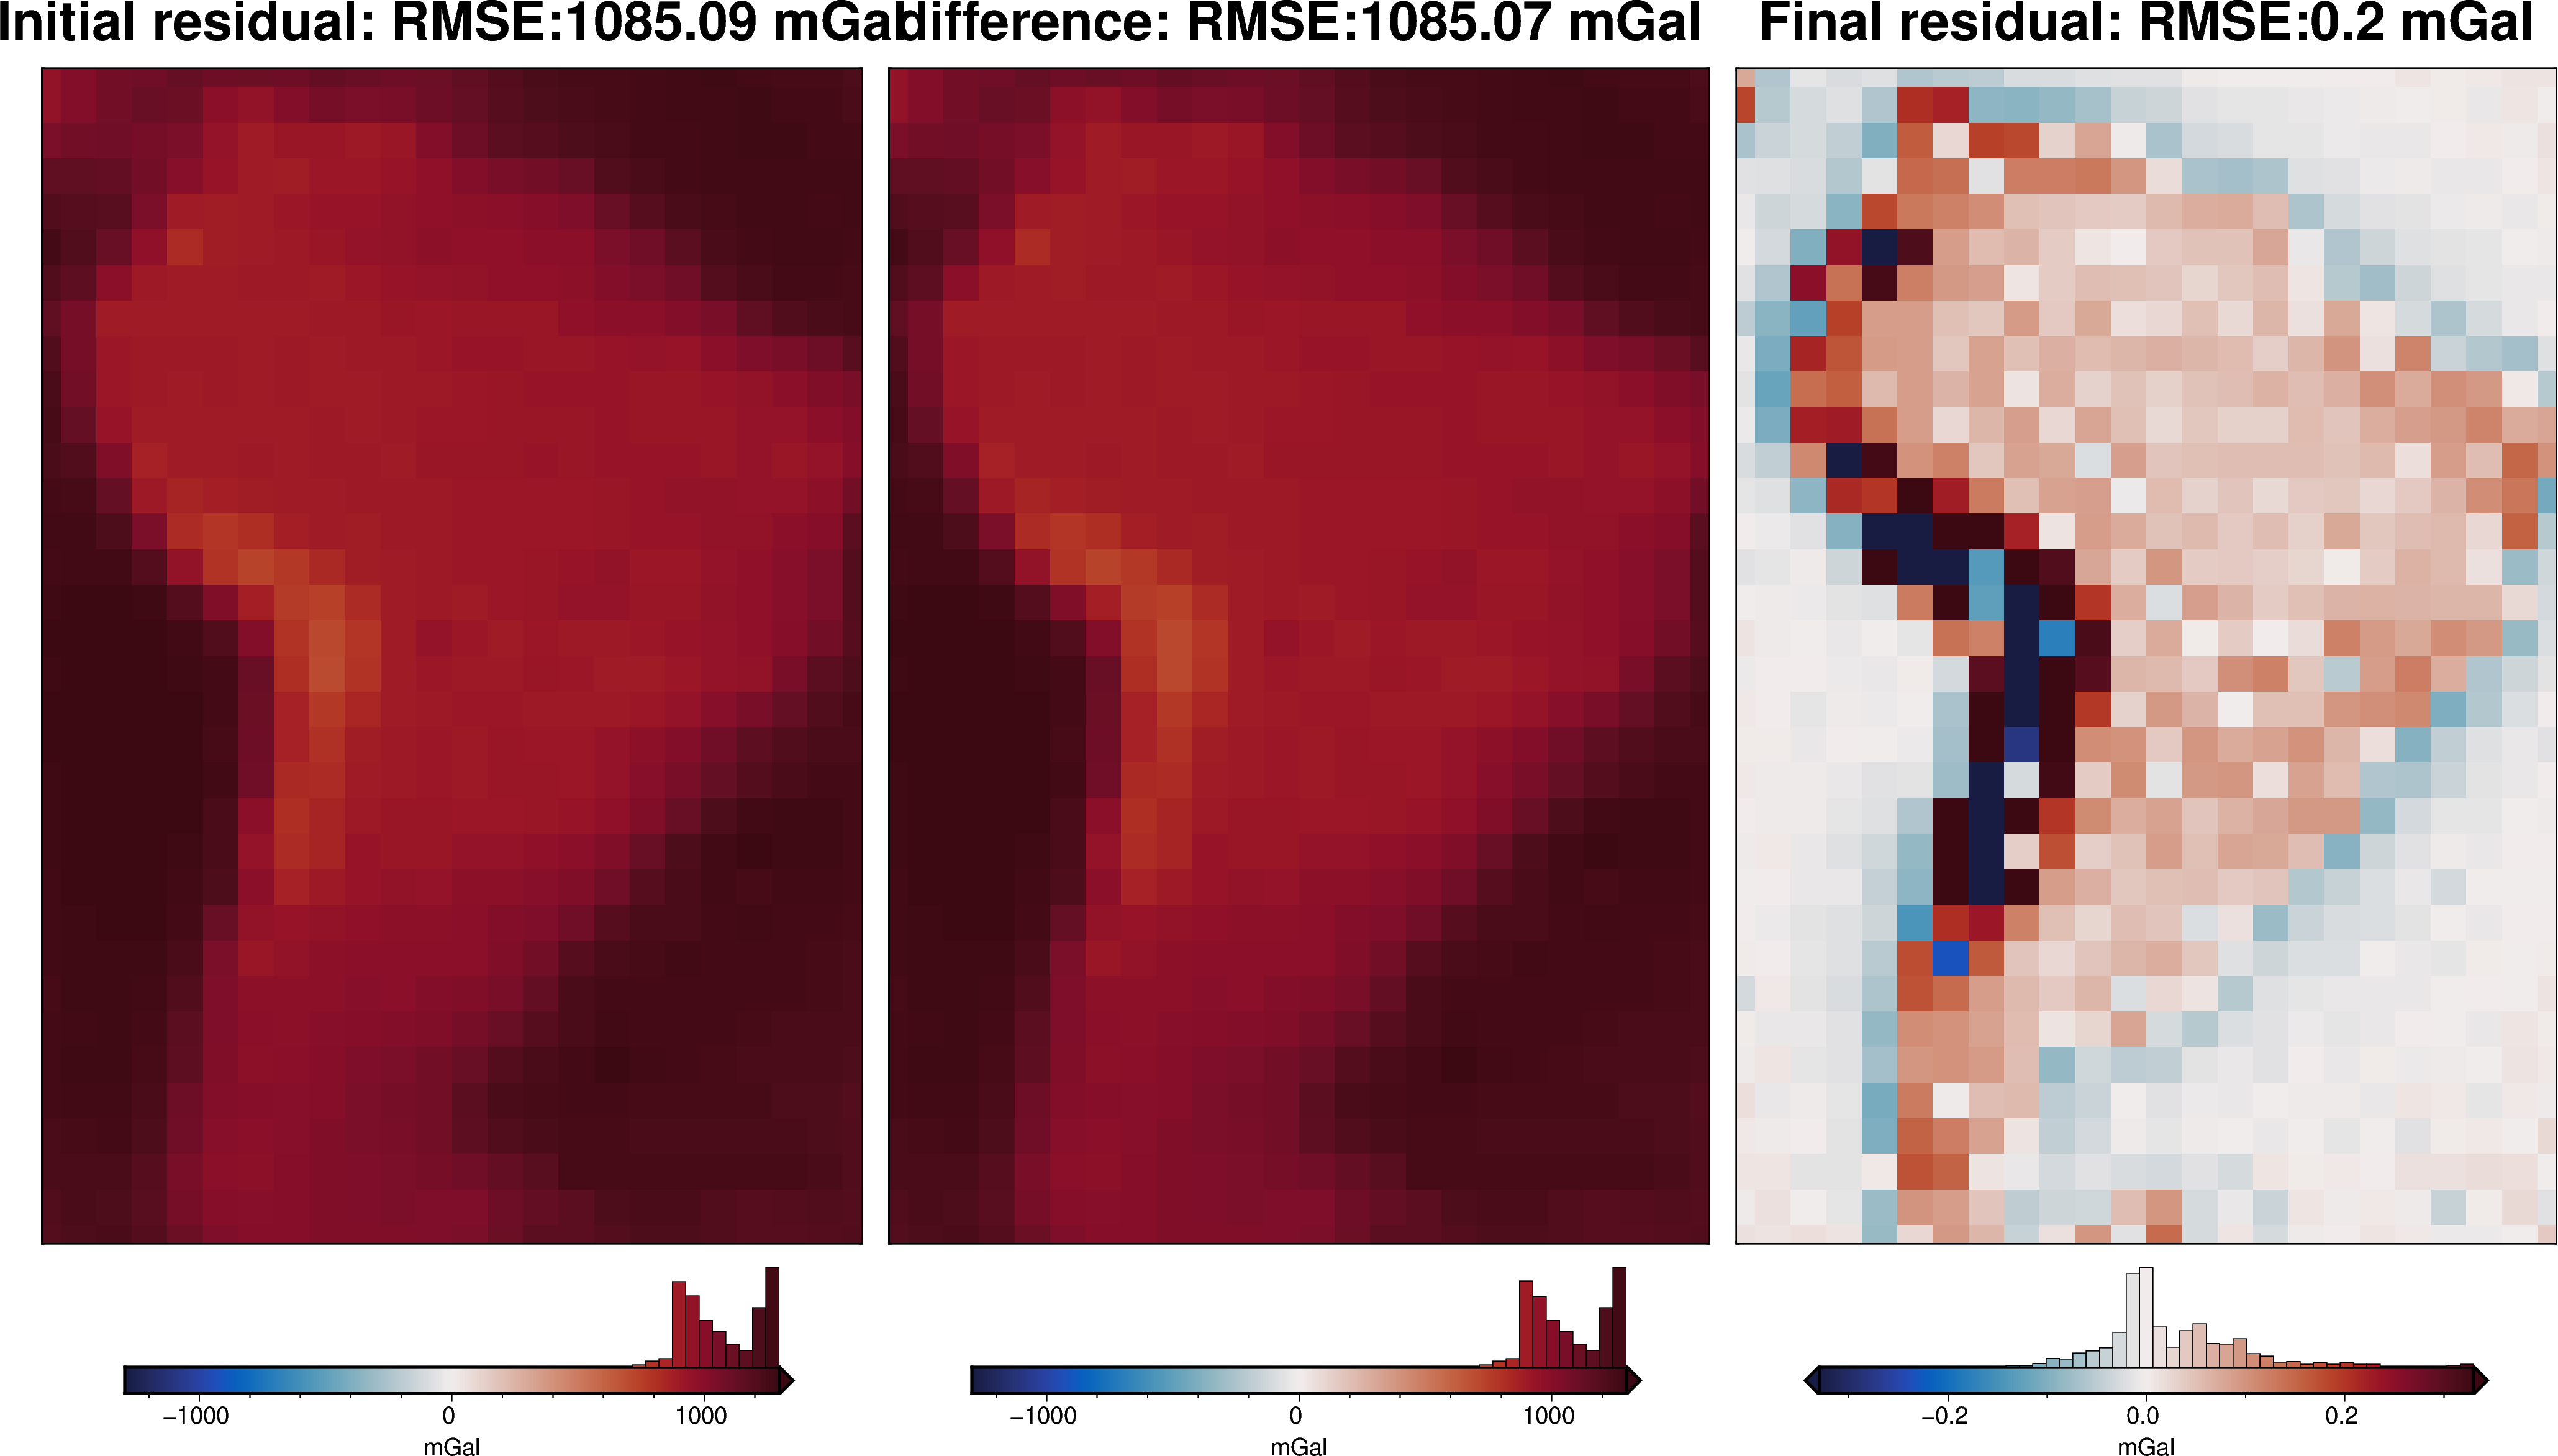

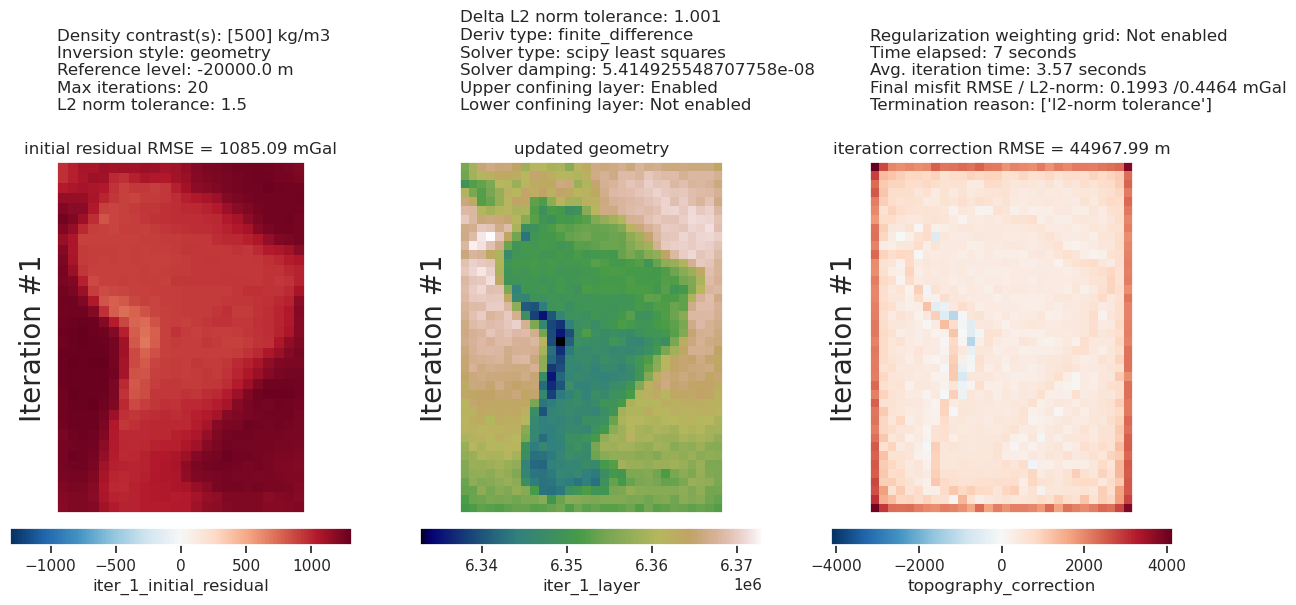

In [79]:
inv.plot_convergence()

inv.plot_inversion_results(
    iters_to_plot=1,
    fig_height=16,
)

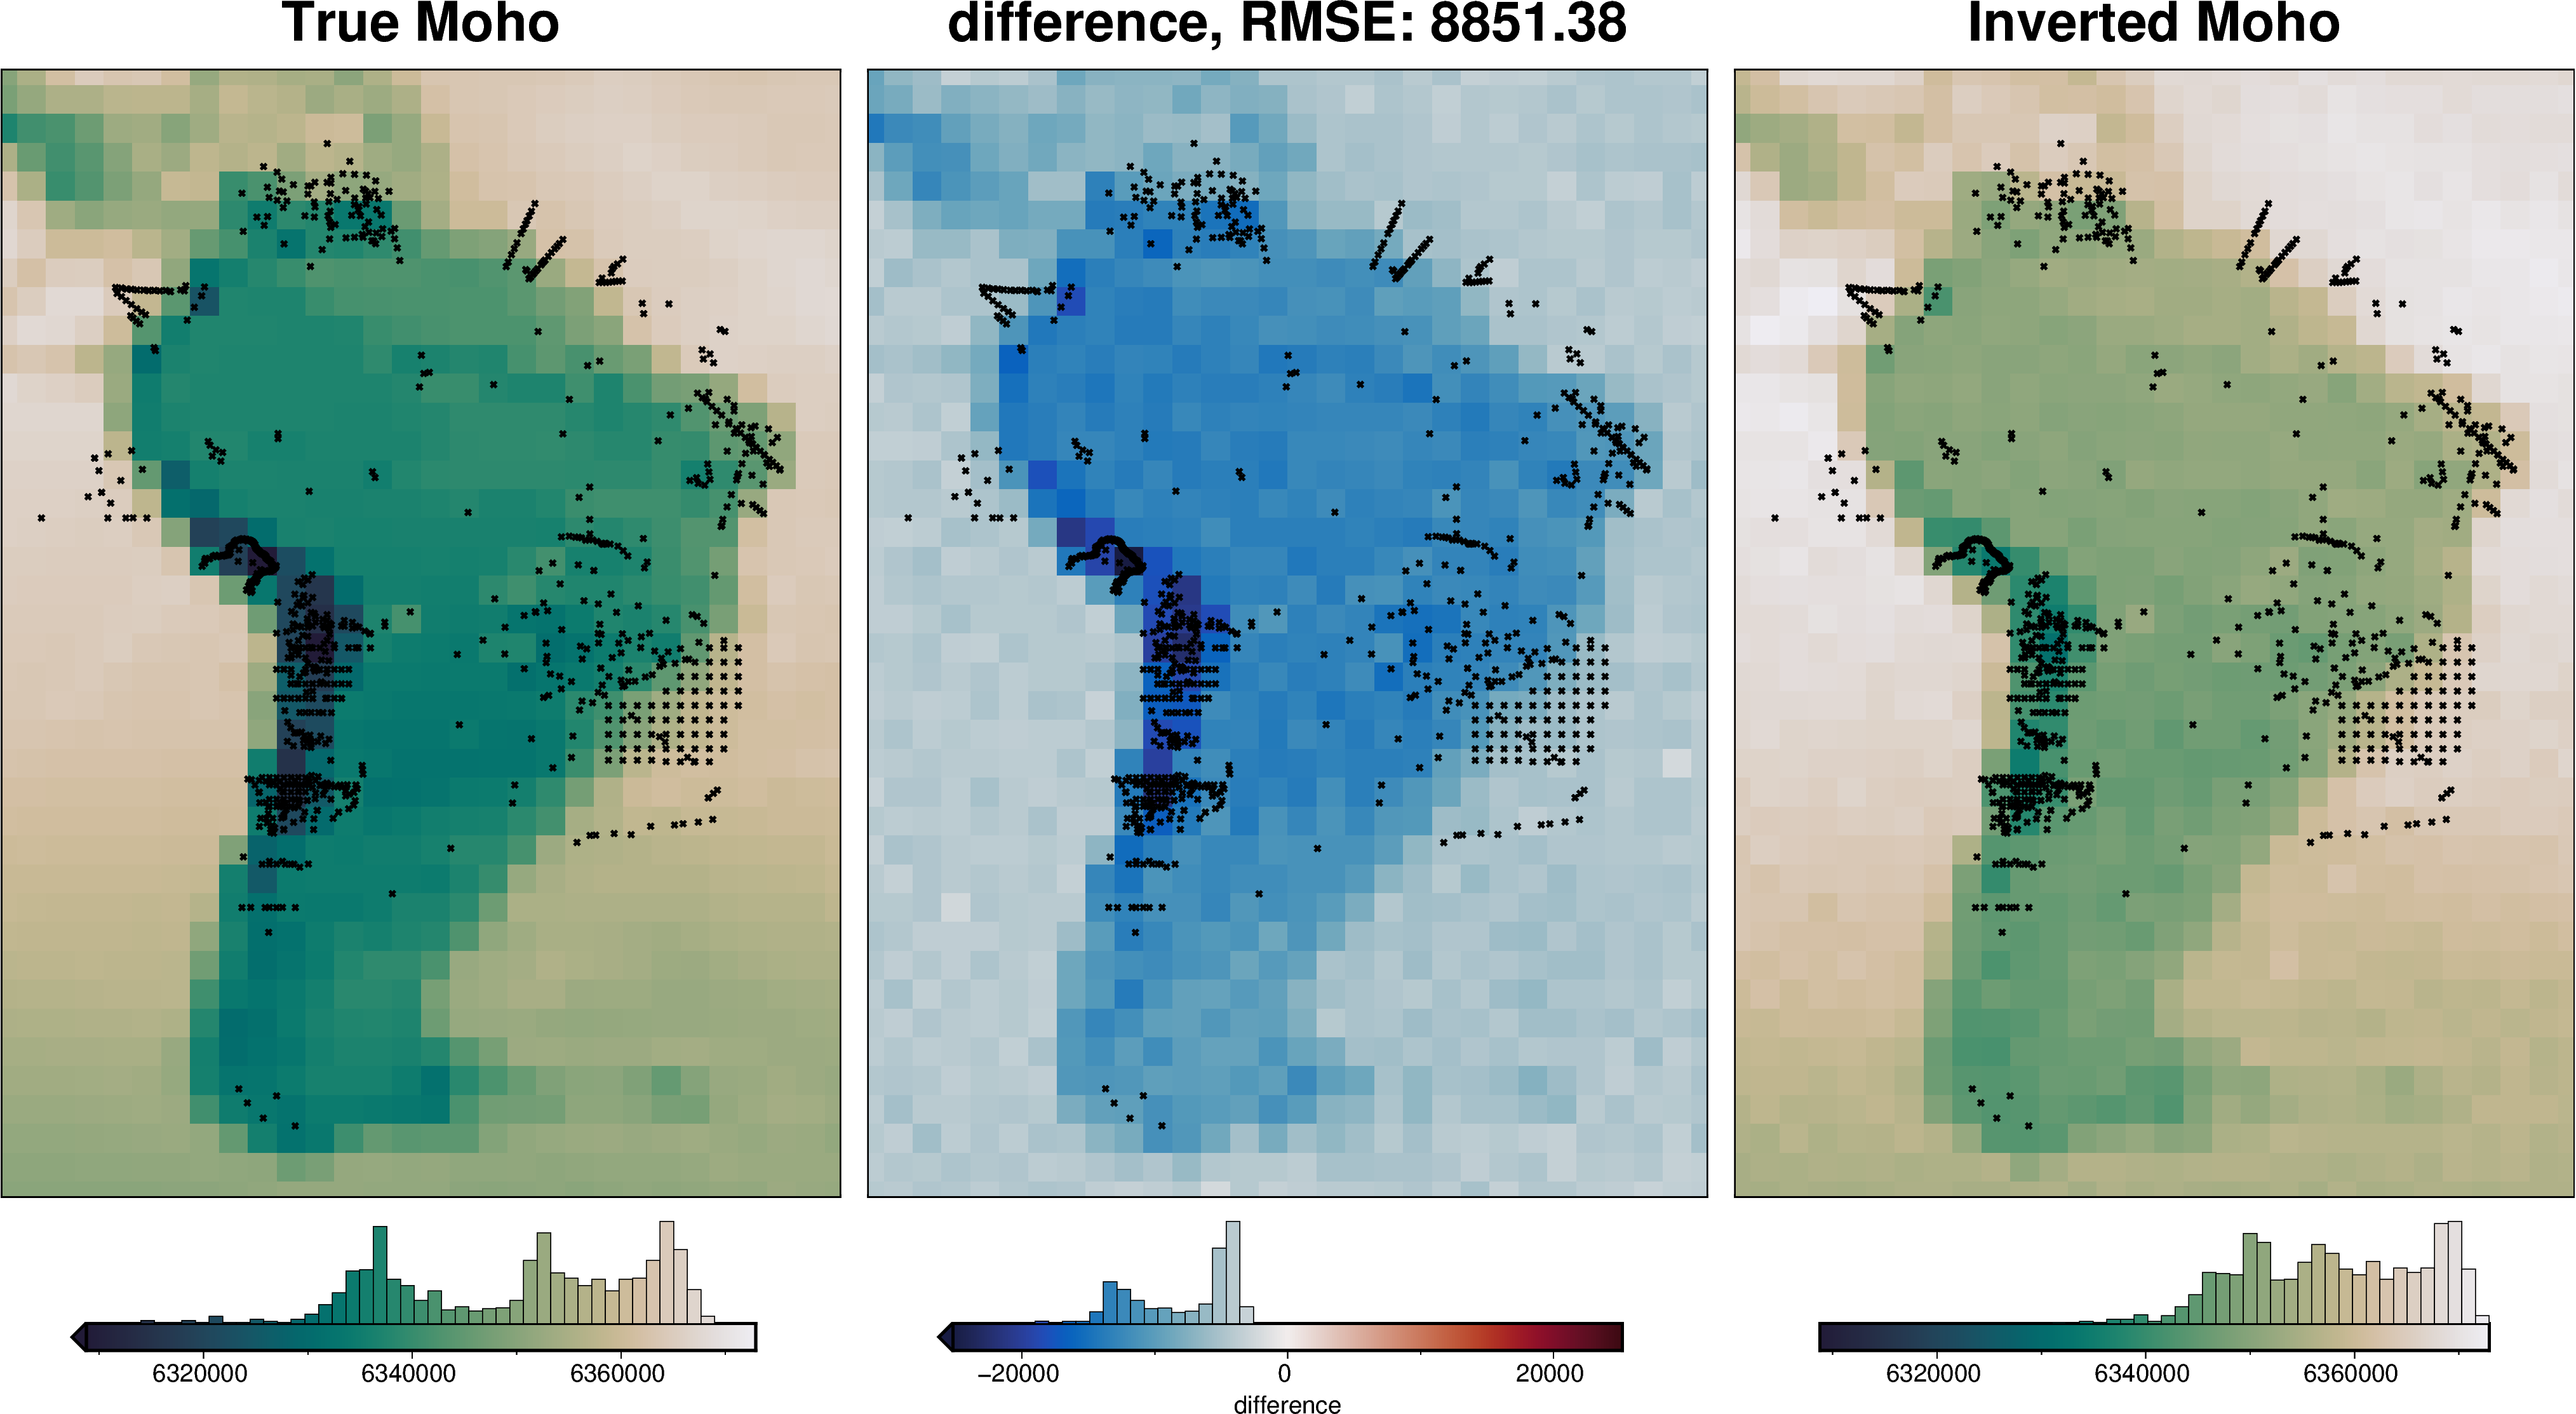

In [80]:
_ = polar_utils.grd_compare(
    true_moho.upward + true_moho.geocentric_radius,
    inv.model.topography,
    grid1_name="True Moho",
    grid2_name="Inverted Moho",
    hist=True,
    inset=False,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"latitude": "y", "longitude": "x"}),
    points_style="x.1c",
)

In [81]:
# sample the inverted topography at the constraint points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    inv.model.topography - inv.model.geocentric_radius,
    "inverted_topography",
    coord_names=inv.model.coord_names,
)

rmse = invert4geom.rmse(
    constraint_points.upward - constraint_points.inverted_topography
)
print(f"RMSE: {rmse:.2f} m")

RMSE: 14678.99 m


## Density / Reference level optimization

Now that we have a optimal damping value, we can perform an optimization to find the optimal values for density contrast and reference level. For these, we pick a range of possible values, and perform a hyperparameter optimization to find the best set of values.

In [ ]:
# we don't need the testing points anymore
inv.data = invert4geom.remove_test_points(inv.data)

In [ ]:
inv.reinitialize_inversion()

In [ ]:
inv.model

<xarray.Dataset> Size: 97kB
Dimensions:                (latitude: 40, longitude: 30)
Coordinates:
  * latitude               (latitude) float64 320B -59.0 -57.0 ... 17.0 19.0
  * longitude              (longitude) float64 240B -89.0 -87.0 ... -33.0 -31.0
    top                    (latitude, longitude) float64 10kB 6.342e+06 ... 6...
    bottom                 (latitude, longitude) float64 10kB 6.302e+06 ... 6...
Data variables:
    density                (latitude, longitude) int64 10kB -100 -100 ... -100
    thickness              (latitude, longitude) float64 10kB 4e+04 ... 4e+04
    starting_topography    (latitude, longitude) float64 10kB 6.302e+06 ... 6...
    topography             (latitude, longitude) float64 10kB 6.302e+06 ... 6...
    mask                   (latitude, longitude) float64 10kB 1.0 1.0 ... 1.0
    geocentric_radius      (latitude, longitude) float64 10kB 6.362e+06 ... 6...
    upper_confining_layer  (latitude, longitude) float64 10kB 3.181e+07 ... 3...
    lower_confining_layer  (latitude, longitude) float64 10kB nan nan ... nan
Attributes:
    inner_region:      (-89.0, -31.0, -59.0, 19.0)
    zref:              -20000.0
    density_contrast:  100
    region:            (-89.0, -31.0, -59.0, 19.0)
    spacing:           2.0
    dataset_type:      model
    model_type:        tesseroids
    coord_names:       ('longitude', 'latitude')

In [ ]:
# run the optimization for the zref and density
density_zref_optimization_obj = inv.optimize_inversion_zref_density_contrast(
    constraints_df=constraint_points,
    density_contrast_limits=(10, 500),  # (200, 500),
    # zref_limits=(-35e3, -20e3),
    n_trials=1,
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    starting_topography_kwargs=dict(
        method="flat",
        projection=pyproj.Proj(proj="merc", lat_ts=inv.model.latitude.values.mean()),  # noqa: PD011
        upward=-60e3,
    ),
    plot_scores=False,
    fname="../tmp/uieda_CRUST1_zref_density_optimization",
)

n_startup_trials is >= n_trials resulting in all trials sampled from a QMC sampler instead of the GP sampler


  0%|          | 0/1 [00:00<?, ?it/s]

starting topo:/n <xarray.Dataset> Size: 39kB
Dimensions:            (longitude: 30, latitude: 40)
Coordinates:
  * longitude          (longitude) float64 240B -89.0 -87.0 ... -33.0 -31.0
  * latitude           (latitude) float64 320B -59.0 -57.0 -55.0 ... 17.0 19.0
    top                (latitude, longitude) float64 10kB 6.342e+06 ... 6.356...
    bottom             (latitude, longitude) float64 10kB 6.302e+06 ... 6.316...
Data variables:
    upward             (latitude, longitude) float64 10kB -2e+04 ... -2e+04
    geocentric_radius  (latitude, longitude) float64 10kB 6.362e+06 ... 6.376...
model:/n <xarray.Dataset> Size: 97kB
Dimensions:                (latitude: 40, longitude: 30)
Coordinates:
  * latitude               (latitude) float64 320B -59.0 -57.0 ... 17.0 19.0
  * longitude              (longitude) float64 240B -89.0 -87.0 ... -33.0 -31.0
    top                    (latitude, longitude) float64 10kB 6.342e+06 ... 6...
    bottom                 (latitude, longitude) float

Best density_contrast value (10) is at the limit of provided values (500, 10) and thus is likely not a global minimum, expand the range of values tested to ensure the best parameter value is found.
'forward_gravity' already a variable of `grav_ds`, but is being overwritten since calculate_starting_gravity is True
'reg' already a column of `grav_df`, but is being overwritten since calculate_regional_misfit is True


In [110]:
density_zref_optimization_obj.model

<xarray.Dataset> Size: 202kB
Dimensions:                (latitude: 40, longitude: 30)
Coordinates:
  * latitude               (latitude) float64 320B -59.0 -57.0 ... 17.0 19.0
  * longitude              (longitude) float64 240B -89.0 -87.0 ... -33.0 -31.0
    top                    (latitude, longitude) float64 10kB 6.371e+06 ... 6...
    bottom                 (latitude, longitude) float64 10kB 6.342e+06 ... 6...
Data variables: (12/19)
    density                (latitude, longitude) int64 10kB 200 200 ... 200 200
    thickness              (latitude, longitude) float64 10kB 0.0 0.0 ... 0.0
    starting_topography    (latitude, longitude) float64 10kB 6.342e+06 ... 6...
    topography             (latitude, longitude) float64 10kB 6.371e+06 ... 6...
    mask                   (latitude, longitude) float64 10kB 1.0 1.0 ... 1.0
    geocentric_radius      (latitude, longitude) float64 10kB 6.362e+06 ... 6...
    ...                     ...
    topography_correction  (latitude, longitude) float64 10kB -3.237e+03 ... ...
    iter_2_top             (latitude, longitude) float64 10kB 6.371e+06 ... 6...
    iter_2_bottom          (latitude, longitude) float64 10kB 6.342e+06 ... 6...
    iter_2_density         (latitude, longitude) int64 10kB 200 200 ... 200 200
    iter_2_layer           (latitude, longitude) float64 10kB 6.371e+06 ... 6...
    iter_2_correction      (latitude, longitude) float64 10kB -3.237e+03 ... ...
Attributes:
    inner_region:      (-89.0, -31.0, -59.0, 19.0)
    zref:              -20000.0
    density_contrast:  200
    region:            (-89.0, -31.0, -59.0, 19.0)
    spacing:           2.0
    dataset_type:      model
    model_type:        tesseroids
    coord_names:       ('longitude', 'latitude')

In [97]:
# to re-load the study from the saved pickle file
with pathlib.Path("../tmp/uieda_CRUST1_zref_density_optimization_study.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)
study.trials_dataframe().sort_values("value")

number         value             datetime_start          datetime_complete  \
0       0  6.378436e+06 2026-01-20 11:31:09.786359 2026-01-20 11:31:18.285943   
6       6  6.378436e+06 2026-01-20 11:32:00.234638 2026-01-20 11:32:09.514458   
5       5  6.378436e+06 2026-01-20 11:31:51.752154 2026-01-20 11:32:00.233385   
4       4  6.378436e+06 2026-01-20 11:31:42.317963 2026-01-20 11:31:51.750880   
7       7  6.378436e+06 2026-01-20 11:32:09.515616 2026-01-20 11:32:19.137549   
2       2  6.380770e+06 2026-01-20 11:31:25.994151 2026-01-20 11:31:33.878863   
3       3  6.387045e+06 2026-01-20 11:31:33.880049 2026-01-20 11:31:42.300768   
1       1  6.389280e+06 2026-01-20 11:31:18.287244 2026-01-20 11:31:25.992846   

                duration  params_density_contrast  \
0 0 days 00:00:08.499584                      200   
6 0 days 00:00:09.279820                      200   
5 0 days 00:00:08.481231                      200   
4 0 days 00:00:09.432917                      200   
7 0 days 00:00:09.621933                      200   
2 0 days 00:00:07.884712                      229   
3 0 days 00:00:08.420719                      380   
1 0 days 00:00:07.705602                      500   

                                    user_attrs_fname  \
0  ../tmp/uieda_CRUST1_zref_density_optimization_...   
6  ../tmp/uieda_CRUST1_zref_density_optimization_...   
5  ../tmp/uieda_CRUST1_zref_density_optimization_...   
4  ../tmp/uieda_CRUST1_zref_density_optimization_...   
7  ../tmp/uieda_CRUST1_zref_density_optimization_...   
2  ../tmp/uieda_CRUST1_zref_density_optimization_...   
3  ../tmp/uieda_CRUST1_zref_density_optimization_...   
1  ../tmp/uieda_CRUST1_zref_density_optimization_...   

   system_attrs_fixed_params     state  
0  {'density_contrast': 200}  COMPLETE  
6                        NaN  COMPLETE  
5                        NaN  COMPLETE  
4                        NaN  COMPLETE  
7                        NaN  COMPLETE  
2                        NaN  COMPLETE  
3                        NaN  COMPLETE  
1  {'density_contrast': 500}  COMPLETE

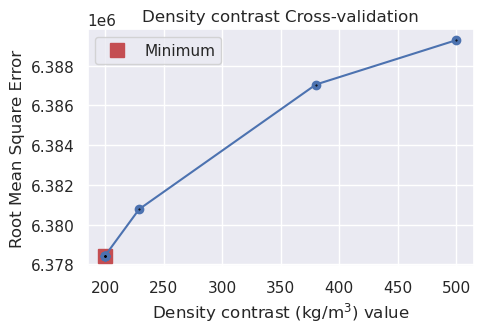

In [96]:
fig = invert4geom.plot_scores(
    study.trials_dataframe().value.to_numpy(),
    study.trials_dataframe().params_density_contrast.to_numpy(),
    param_name="Density contrast (kg/m$^3$)",
    plot_title="Density contrast Cross-validation",
    logx=False,
    logy=False,
)
fig.show()

In [ ]:
fig = invert4geom.plot_2_parameter_scores_uneven(
    study,
    param_names=(
        "params_zref",
        "params_density_contrast",
    ),
    plot_param_names=(
        "Reference level (m)",
        "Density contrast (kg/m$^3$)",
    ),
)

TypeError: plot_2_parameter_scores_uneven() missing 1 required positional argument: 'param_names'

In [ ]:
best_zref = study.best_params.get("zref")
best_density_contrast = study.best_params.get("density_contrast")

print(f"Optimal zref: {best_zref / 1e3:.1f} km")
print(f"True zref: {true_zref / 1e3:.1f} km")
print(f"Optimal density contrast: {best_density_contrast:.1f} kg/m³")
print(f"True density contrast: {true_density_contrast:.1f} kg/m³")

In [ ]:
# we can also access the optimally-determined values through the `inv` object
print(f"Solver damping: {inv.solver_damping}")
print(f"Zref: {inv.model.zref / 1e3:.1f} km")
print(f"Density contrast: {inv.model.density_contrast:.1f} kg/m³")

The above plot shows the results of the cross validation and is equivalent to Figure 7b in the paper. The optimal values they report are zref = 30 km and density contrast = 350 kg/m-3, which are roughly the same as the values we find. The main difference is that they used a grid-search approach, testing evenly-spaced values between -35 and -20 km, and between 500 and 200 kg/m-3. We instead used an optimization approach, where the parameters space is smartly searched based on the scores of the past trials. As you can see, this allows us to find the optimal values in far fewer trials. Here we used 20 trials, compared to the 49 trials used in the paper.

We also support the grid-search approach, which can be enabled with `grid_search=True` in the above function.

### Plot results

The below plots show the inversion results used the optimal damping, density contrast, and reference level values. 

In [ ]:
inv.plot_convergence()

In [ ]:
inv.plot_inversion_results(iters_to_plot=2)

The second plot above compares gravity misfit before and after the inversion. The right subplot is equivalent to Figure 7g in the paper. 

The lower plot shows the iteration results of the inversion, and has all the parameter values and metadata at the top. From this, you can see the inversion terminated after 3 iterations due to the inversion reaching the set L2-norm tolerance. 

In [ ]:
_ = polar_utils.grd_compare(
    true_moho.upward + true_moho.geocentric_radius,
    inv.model.topography,
    grid1_name="True Moho",
    grid2_name="Inverted Moho",
    hist=True,
    inset=False,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"latitude": "y", "longitude": "x"}),
    points_style="x.1c",
)

The above plot shows the difference between the true and inverted topography and is equivalent to Figure 6d in the paper. The colorbar histogram of the middle subplot is equivalent to Figure 6f. The errors are normally distributed around ~0, with a RMS of ~1100 m.

In [ ]:
# sample the inverted topography at the constraint points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    inv.model.topography - inv.model.geocentric_radius,
    "inverted_topography",
    coord_names=inv.model.coord_names,
)

rmse = invert4geom.rmse(
    constraint_points.upward - constraint_points.inverted_topography
)
print(f"RMSE: {rmse:.2f} m")

## Repeat with adhering to constraints
The above inversions only used the constraint points as a means to perform the cross validation. Below we will create a starting model from these points and attempt to make the inversion adhere to the constraints.

### Starting model

In [ ]:
starting_topography.upward

In [ ]:
# grid the sampled values using verde
starting_topography = invert4geom.create_topography(
    coord_names=inv.model.coord_names,
    projection=pyproj.Proj(proj="merc", lat_ts=inv.model.latitude.values.mean()),  # noqa: PD011
    region=grav_data.region,
    spacing=grav_data.spacing,
    dataarray_to_add=inv.model.geocentric_radius,
    upper_confining_layer=xr.full_like(starting_topography.upward, 0),
    # method="flat",
    # upward=-30e3,
    method="splines",
    constraints_df=constraint_points,
    dampings=None,  # np.logspace(-20, 0, 4),
    block_size=2,
)

_ = polar_utils.grd_compare(
    true_moho.upward,
    starting_topography.upward,
    fig_height=20,
    region=grav_data.region,
    grid1_name="True Moho",
    grid2_name="Starting Moho",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"latitude": "y", "longitude": "x"}),
    points_style="x.1c",
)

In [ ]:
# sample the inverted topography at the constraint points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    starting_topography.upward,
    "starting_topography",
    coord_names=inv.model.coord_names,
)

rmse = invert4geom.rmse(
    constraint_points.upward - constraint_points.starting_topography
)
print(f"RMSE: {rmse:.2f} m")

### Use a weighting grid
To ensure the inversion doesn't alter the starting model at the constraint points, where we know what the Moho elevation is, we can use a weighting grid. This scales each iterations correction values to be 0 at the constraint points. It's a good idea to redo the damping parameter CV when using this since the optimal damping value will likely change when you're using a weighting grid.

In [ ]:
# calculate the distance between each grid cell and the nearest constraint, then
# normalize those values between 0 and 1
weighting_grid = invert4geom.normalized_mindist(
    constraint_points,
    model.starting_topography,
    low=0,
    high=1,
)
weighting_grid.plot()

### Damping CV

In [ ]:
weighted_results = invert4geom.run_inversion_workflow(
    grav_ds=grav_data,
    model_type="tesseroids",
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    run_damping_cv=True,
    constraints_df=constraint_points,
    density_contrast=best_density_contrast,
    zref=best_zref,
    fname="../tmp/uieda_CRUST1_with_starting_model",
    starting_topography=starting_topography,
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    inversion_kwargs={
        "deriv_type": "finite_difference",
        "max_iterations": 20,
        "l2_norm_tolerance": 2.2,
        "delta_l2_norm_tolerance": 1.01,
        "apply_weighting_grid": True,
        "weighting_grid": weighting_grid,
    },
    damping_cv_kwargs={
        "damping_limits": (1e-12, 1e-2),
        "n_trials": 10,
        "n_startup_trials": 5,
        "plot_scores": True,
    },
)

In [ ]:
# to re-load the inversion results from the saved pickle file
name = "../tmp/uieda_CRUST1_with_starting_model.pickle"
with pathlib.Path(name).open("rb") as f:
    weighted_results = pickle.load(f)

In [ ]:
# sample the inverted topography at the constraint points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    weighted_results.model.topography - weighted_results.model.geocentric_radius,
    "inverted_topography",
    coord_names=weighted_results.model.coord_names,
)

rmse = invert4geom.rmse(
    constraint_points.upward - constraint_points.inverted_topography
)
print(f"RMSE: {rmse:.2f} m")

The inversion error without a starting model was ~1100 m, and 1050 m at constraint points. Including a starting model and weighting grid reduced the error at constraint points to 230 m, while the overall error of the inverted Moho remained similar.

In [ ]:
weighted_results.plot_inversion_results(iters_to_plot=2)

In [ ]:
_ = polar_utils.grd_compare(
    true_moho.upward + true_moho.geocentric_radius,
    weighted_results.model.topography,
    fig_height=20,
    region=grav_data.region,
    grid1_name="True Moho",
    grid2_name="Inverted Moho",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"latitude": "y", "longitude": "x"}),
    points_style="x.1c",
)